# **What could be influencing employees to leave the organisation?**

![Image_2.jpg](images/Image_2.jpg)

## Introduction

Employee turnover describes the number or percentage of employees leaving an organisation during a specified time period, and who usually must be replaced. High rates of turnover are usually associated with:

- increased recruitment costs (according to a recent Gallup poll, the costs associated with replacing a single employee can be as much as twice that employee's annual salary)
- decreased productivity, and
- lower employee morale. Whilst a zero turnover rate is unrealistic and turnover tends to vary by industry, the average staff turnover rate according to the SHRM Human Capital Benchmarking Report across all industries is about 18%.

Employee turnover can occur for a number of different reasons: Some people switch careers, others move on due to toxic work environments, and still others move on because they receive a better offer elsewhere or due to changes in personal circumstances. That being said, most voluntary resignations occur due to management problems, lack of opportunities or burnout.

The goal of the following analysis was to use available internal employee data to better understand the turnover situation in the department, which types of employees were more likely to leave and why, and use those insights to present recommendations on how to tackle the issue.

The Board specifically requested answers to the following questions:

- Which department has the highest employee turnover? Which one has the lowest?
- Investigate which variables seem to be better predictors of employee departure.
- How could the organisation reduce employee turnover?

## Data and Methods

The data was collated from exit interviews, performance reviews and employee records of 9,540 employees. The variables provided were:

- "department" - the department the employee belongs to.
- "promoted" - 1 if the employee was promoted in the previous 24 months, 0 otherwise.
- "review" - the composite score the employee received in their last evaluation; 0 to 1.
- "projects" - how many projects the employee was involved in.
- "salary" - for confidentiality reasons, salary was tiered: low, medium, high.
- "tenure" - how many years the employee had been at the company.
- "satisfaction" - the level of employee satisfaction, based on surveys; 0 to 1.
- "bonus" - 1 if the employee had received a bonus, 0 otherwise.
- "avg_hrs_month" - the average hours the employee worked in a month.
- "left" - "yes" if the employee had ended up leaving, "no" otherwise.

A preliminary exploratory data analysis was first conducted to determine if there were any initial useful insights regarding the relationship between turnover status and the available employee characteristics, and what interactions were present between the employee characteristics. The second half of the analysis involved a multi-step process:

- splitting the dataset into a training and test set using an 80:20 ratio, stratifying by the class proportions of the target variable
- one-hot/dummy encoding the categorical and binary features and standardising all input features to take a mean of 0 and standard deviation of 1 where necessary
- training ten different candidate machine learning algorithms on the training subset of the dataset
- assessing model performance using a number of different classification metrics such as F1 score, Area under the Receiver Operating Characteristic (AUROC) and Precision-Recall Curves (AUPRC) and against a baseline model that only ever predicted the majority class
- tuning the hyperparameters of a short-listed set of candidate models using 5-fold stratified cross-validation
- making a final selection and assessing feature importance.

The candidate classifiers were:

- Adaptive boosting (with a decision tree as the base estimator; AdaBoost)
- Categorical boosting (CatBoost)
- Decision tree
- Extra trees (randomized decision trees)
- Gradient boosting (GBM)
- K-Nearest neighbours (KNN)
- Logistic regression
- Gaussian naive bayes
- Random forest
- Support vector machine (SVM)

In order to account for the unbalanced turnover status proportions (~30% left and 70% stayed), class weights were adjusted such that they were inversely proportional to class frequencies in the input data for all algorithms that included such a parameter.

In [1]:
%%capture
!pip install --upgrade pip
!pip install dython catboost shap
!pip install numpy==1.21.4 numba==0.53.0 matplotlib==3.4.0 --upgrade

In [2]:
# import libraries
import catboost 
import dython
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import time

from scipy.stats import chi2_contingency, mannwhitneyu, shapiro, ttest_ind

from collections import namedtuple
from itertools import chain

from dython.nominal import associations, identify_nominal_columns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz

from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

In [3]:
data = pd.read_csv('./data/employee_churn_data.csv')
#data.head()
#data.describe()
#data.info()

## Results

### Target - feature variable relationships

In [4]:
# convert all relevant features into categorical variables
category_vars = ['department', 'promoted', 'salary', 'bonus', 'left']
numeric_vars = ['review', 'projects', 'tenure', 'avg_hours_month']

data[category_vars] = data[category_vars].apply(lambda x: x.astype('category'))

# rename specific categories
binary_changes = {0: "no", 1: "yes"}
data[['promoted', 'bonus']] = data[['promoted', 'bonus']].apply(lambda x: x.cat.rename_categories(binary_changes))

# set 'salary' as an ordered feature
data['salary'].cat.reorder_categories(new_categories = ['low', 'medium', 'high'], ordered=True, 
                                      inplace=True)

# change 'tenure' from a float to an integer
data['tenure'] = data['tenure'].astype('int64')

# take a look at the new data types
#data.info()
#data.head()

Whilst the overall employee turnover rate was 29.2%, Figure 1 clearly indicated that there were slightly differing rates by department. Finance was the lowest at 26.9% and IT was the highest at 30.9%, closely followed by Logistics at 30.8%.

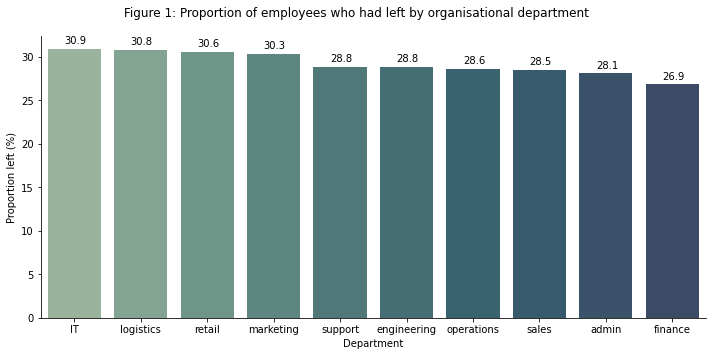

In [5]:
# left by department
# create the summary table of proportions
temp = data.groupby("department")["left"].value_counts(normalize=True)
temp = pd.DataFrame(temp).reset_index()
temp.columns = ['department', 'left', 'prop']
temp.prop = temp.prop.mul(100)
temp = temp[temp.left == "yes"]
temp = temp.sort_values("prop", ascending=False).reset_index()

# create the x-axis sort order
dept_order = list(temp["department"])

# plot the turnover rates by department
p = sns.catplot(x="department", y="prop", data=temp, order=dept_order, kind="bar", 
                height=5, aspect=2, saturation=0.5, palette="crest")
p.set_axis_labels("Department", "Proportion left (%)")
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle("Figure 1: Proportion of employees who had left by organisational department");

# extract the matplotlib axes_subplot objects from the FacetGrid
ax = p.facet_axis(0,0)
# iterate through the axes patches
for pat in ax.patches:
    ax.text(pat.get_x() + 0.25, 
            pat.get_height() * 1.02, 
           '{0:.1f}'.format(pat.get_height()),
            color='black', 
            rotation = 'horizontal', 
            size = 'medium')

Figure 2 displays the proportions of employees by turnover status, against whether they had received a promotion or bonus in the last 24 months, and their salary range. The first subplot indicates that a higher proportion of employees had stayed with the organisation if they had received a promotion. However, the second two indicate that whether an employee had received a bonus or not, and what level of salary they received had had no significant impact (non-statistically) on turnover status.

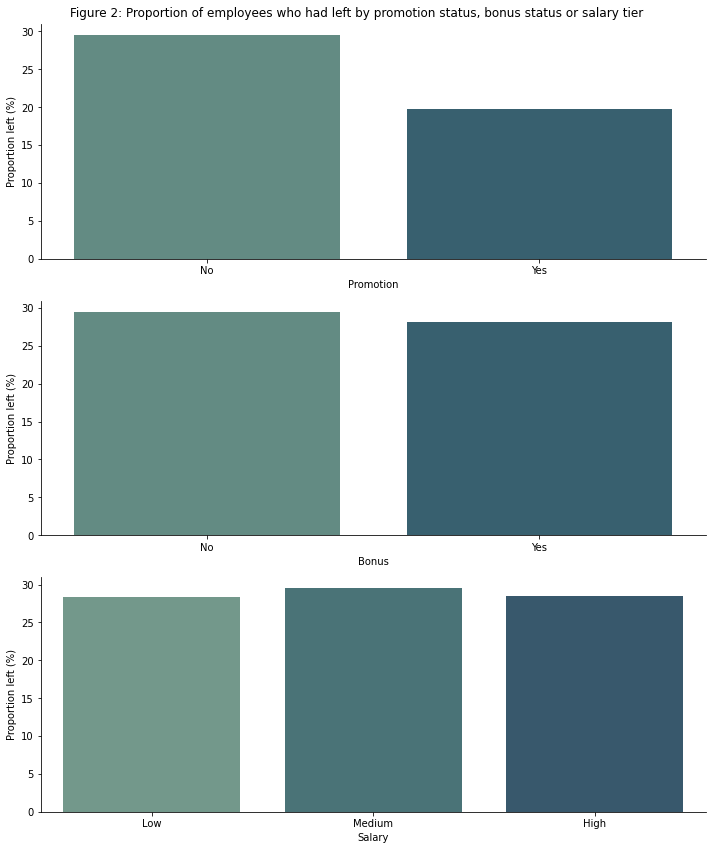

In [6]:
# create the summary tables of proportions
temp_p = data.groupby("promoted")["left"].value_counts(normalize=True)
temp_p = pd.DataFrame(temp_p).reset_index()
temp_p.columns = ['promoted', 'left', 'prop']
temp_p.prop = temp_p.prop.mul(100)
temp_p = temp_p[temp_p.left == "yes"]

temp_b = data.groupby("bonus")["left"].value_counts(normalize=True)
temp_b = pd.DataFrame(temp_b).reset_index()
temp_b.columns = ['bonus', 'left', 'prop']
temp_b.prop = temp_b.prop.mul(100)
temp_b = temp_b[temp_b.left == "yes"]

temp_s = data.groupby("salary")["left"].value_counts(normalize=True)
temp_s = pd.DataFrame(temp_s).reset_index()
temp_s.columns = ['salary', 'left', 'prop']
temp_s.prop = temp_s.prop.mul(100)
temp_s = temp_s[temp_s.left == "yes"]

# create the charts
fig, axs = plt.subplots(3, 1, figsize=(10,12))

p = sns.barplot(x="promoted", y="prop", data=temp_p, saturation=0.5, palette="crest", ax=axs[0])
p.set(xlabel="Promotion", ylabel="Proportion left (%)")
p.set_xticklabels(["No", "Yes"])

b = sns.barplot(x="bonus", y="prop", data=temp_b, saturation=0.5, palette="crest", ax=axs[1])
b.set(xlabel="Bonus", ylabel="Proportion left (%)")
b.set_xticklabels(["No", "Yes"])

s = sns.barplot(x="salary", y="prop", data=temp_s, saturation=0.5, palette="crest", ax=axs[2])
s.set(xlabel="Salary", ylabel="Proportion left (%)")
s.set_xticklabels(["Low", "Medium", "High"])

sns.despine()
fig.suptitle("Figure 2: Proportion of employees who had left by promotion status, bonus status or salary tier")
fig.tight_layout();

Figure 3 displays the proportions of employees by turnover status against the number of projects the employee had been involved in and the length of their tenure in years respectively. The subplot on the left indicates that as the number of projects an employee was involved in had increased, the proportion of employees who left marginally decreased. The subplot on the right indicates a somewhat complex relationship between turnover status and length of tenure. That is, the greatest proportion of employees had left after they had been at the organisation for only two years[^1], and the proportion steadily decreased until six years, at which point there was a spike at years 6 and 7 before dropping to virtually zero.


----------
[^1]: In the data made available for this analysis, there were no employees that had been with the organisation for less than two years.

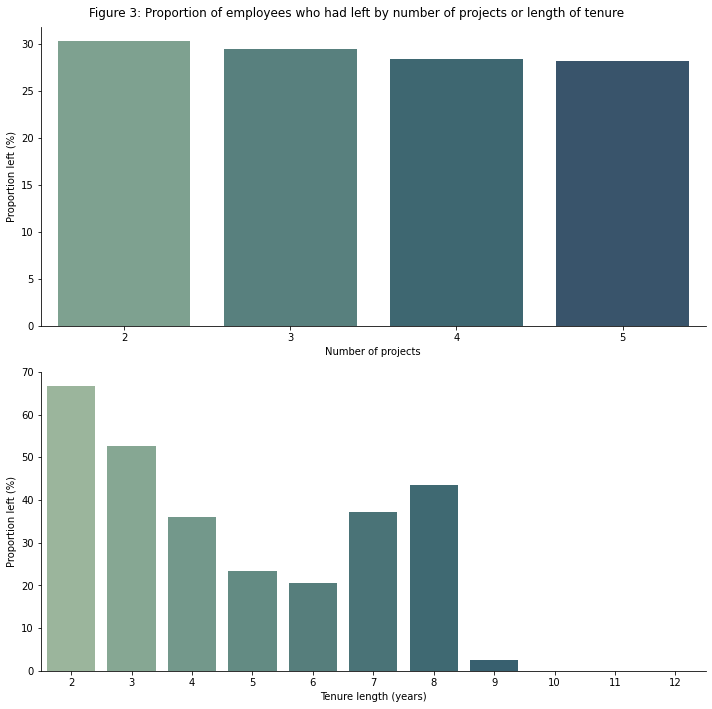

In [7]:
# create the summary tables of proportions
temp_p = data.groupby("projects")["left"].value_counts(normalize=True)
temp_p = pd.DataFrame(temp_p).reset_index()
temp_p.columns = ['projects', 'left', 'prop']
temp_p.prop = temp_p.prop.mul(100)
temp_p = temp_p[temp_p.left == "yes"]

temp_t = data.groupby("tenure")["left"].value_counts(normalize=True)
temp_t = pd.DataFrame(temp_t).reset_index()
temp_t.columns = ['tenure', 'left', 'prop']
temp_t.prop = temp_t.prop.mul(100)
temp_t = temp_t[temp_t.left == "yes"]

# create the charts
fig, axs = plt.subplots(2, 1, figsize=(10,10))
b = sns.barplot(x="projects", y="prop", data=temp_p, saturation=0.5, palette="crest", ax=axs[0])
b.set(xlabel="Number of projects", ylabel="Proportion left (%)")

s = sns.barplot(x="tenure", y="prop", data=temp_t, saturation=0.5, palette="crest", ax=axs[1])
s.set(xlabel="Tenure length (years)", ylabel="Proportion left (%)")

sns.despine()
fig.suptitle("Figure 3: Proportion of employees who had left by number of projects or length of tenure")
fig.tight_layout();

Figures 4 to 6 display the distributions of employee composite review scores, satisfaction scores and average hours worked in a month by turnover status. Figure 4 was interesting in that it indicated that, in general, employees who had left the organisation had received higher evaluation scores. Meanwhile, the slight right-skew in the distribution of satisfaction scores for those employees who had left the organisation indicated that a greater proportion were less satisfied relative to those that had not left. Finally, the distributions by average hours worked indicated that employees who had left had tended to work longer hours compared to their counterparts who had stayed.

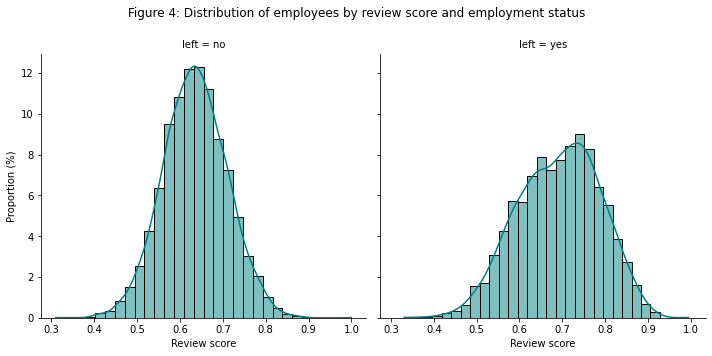

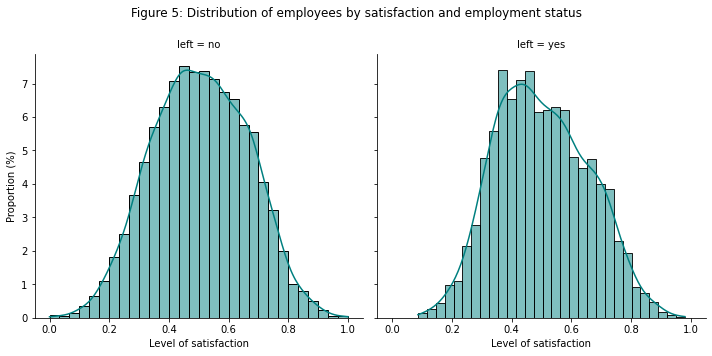

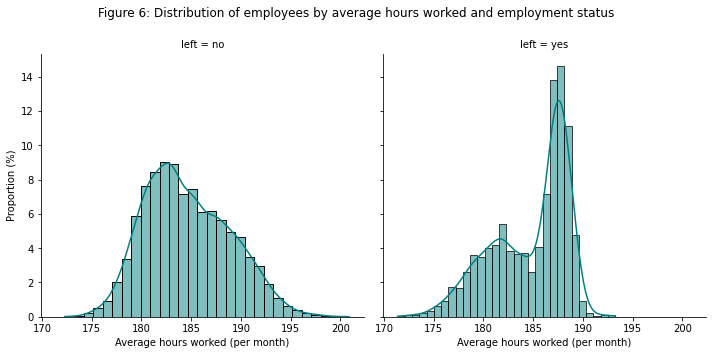

In [8]:
r = sns.FacetGrid(data, col="left", height=5, aspect=1)
r.map_dataframe(sns.histplot, x="review", kde=True, stat='percent', bins=30, color="teal")
r.set_axis_labels("Review score", "Proportion (%)")
r.fig.subplots_adjust(top=0.85)
r.fig.suptitle("Figure 4: Distribution of employees by review score and employment status");

s = sns.FacetGrid(data, col="left", height=5, aspect=1)
s.map_dataframe(sns.histplot, x="satisfaction", kde=True, stat='percent', bins=30, color="teal")
s.set_axis_labels("Level of satisfaction", "Proportion (%)")
s.fig.subplots_adjust(top=0.85)
s.fig.suptitle("Figure 5: Distribution of employees by satisfaction and employment status");

h = sns.FacetGrid(data, col="left", height=5, aspect=1)
h.map_dataframe(sns.histplot, x="avg_hrs_month", kde=True, stat='percent', bins=30, color="teal")
h.set_axis_labels("Average hours worked (per month)", "Proportion (%)")
h.fig.subplots_adjust(top=0.85)
h.fig.suptitle("Figure 6: Distribution of employees by average hours worked and employment status");

A series of statistical tests between turnover status and each of the features generally confirmed these observations. That is, there was found to be a statistically significant relationship between turnover status and each of promotion status, length of tenure, review score and average hours worked at the 95% confidence level. However, there was found to be no statistically significant relationship between department, salary tier, bonus status, number of projects and interestingly, employee satisfaction (Appendix A).

### Variable correlations

Calculating the correlations[^2] between the variables in the dataset indicated that there were largely no strong[^3] linear relationships present, except for that between average hours worked and length of tenure (0.98). With respect to the relationships between the feature and target variables, there was also only a single weak positive relationship between review score and turnover status (0.3). That being said, the direction of this relationship was consistent with Figure 4.

In terms of the feature variables, there were weak negative linear relationships between review score and employee satisfaction (-0.35) and average hours worked (-0.2), and very weak relationships between length of tenure and review score (-0.18), length of tenure and employee satisfaction (-0.15), and employee satisfaction and average hours worked (-0.15).  The direction of these apparent relationships were somewhat contradictory to what would have been expected; for example, it have been more normal to assume that review scores and employee satisfaction was positively associated. However, one explanation for these results could be the presence of Simpson's Paradox, in which a confounding factor that has not been accounted for has reversed the true direction of correlation. 


----------
[^2]: Due to the presence of categorical and numeric variables, three different measures of correlation were used with the assistance of the dython library. Pearson's R was used for continuous-continuous pairwise combinations, the Correlation Ratio for categorical-continuous combinations and Cramer's V for categorical-categorical cases.

[^3]: There is no universal guide as to how differentiate between a 'strong', 'moderate', and 'weak' relationship as it depends on a whole range of factors, including the particular dataset at hand, but a rough rule of thumb is:

- < 0.2      ~ No/very weak association
- 0.2 to 0.4 ~ Weak association
- 0.4 to 0.6 ~ Moderate association
- 0.6 to 0.8 ~ Strong associaton
- \> 0.8      ~ Very strong association

In [9]:
# return category data types to objects (dython doesn't like the former)
# https://blog.knoldus.com/how-to-find-correlation-value-of-categorical-variables/
data2 = data.copy(deep=True)
data2[category_vars] = data2[category_vars].apply(lambda x: x.astype(object))

# generate the baseline correlation matrix
complete_correlations = associations(data2, compute_only=True, title="Figure x")['corr']

# plot the 'prettier' version
print("Figure 7: Variable correlations")
complete_correlations.dropna(axis=1, how='all').dropna(axis=0, how='all').style.background_gradient(cmap='mako_r', axis=None).set_precision(2)

Figure 7: Variable correlations


### Feature - feature variable relationships

In [10]:
# identify the non-numeric features
cat_X = ['department', 'promoted', 'bonus']
ord_X = ['salary']

# specify salary label order
salary_order = ['low', 'medium', 'high']

# create the column transformers
sal_encoder = OrdinalEncoder(categories=[salary_order])
cat_encoder = OrdinalEncoder() # order doesn't matter

# transform the data
data_num = data2.copy(deep=True)
data_num[ord_X] = sal_encoder.fit_transform(data_num[ord_X]).astype('int')
data_num[cat_X] = cat_encoder.fit_transform(data_num[cat_X]).astype('int')

The objective of this section was to uncover any additional insights about employee turnover through the examination of the bivariate relationships between the different features and also identify if there were any employee stereotype clusters. The focus was therefore on the numeric features and any ordinal features with higher cardinality (that is, number of projects and length of tenure).

1. Figure 8 confirmed the presence of the negative relationship between review score and employee satisfaction, although it was stronger in the cohort of employees who had left.
2. Both figures 9 and 10 indicated that employees that had left could be separated into two clusters, and primarily on the average number of hours worked (approximately 185 hours). When additional features were created in the dataset, about 50% of all employees were *just-a-job* employees and 40% worked in excess of around 185 hours per month.

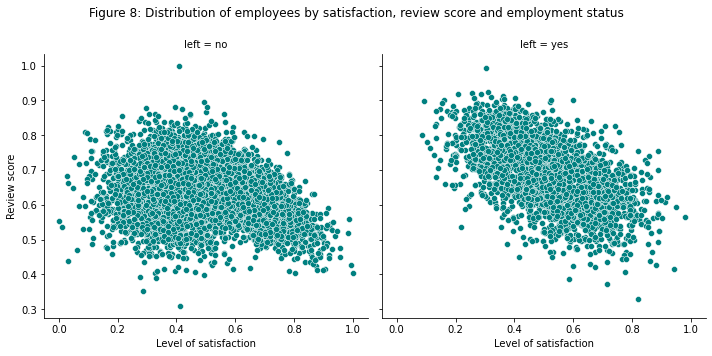

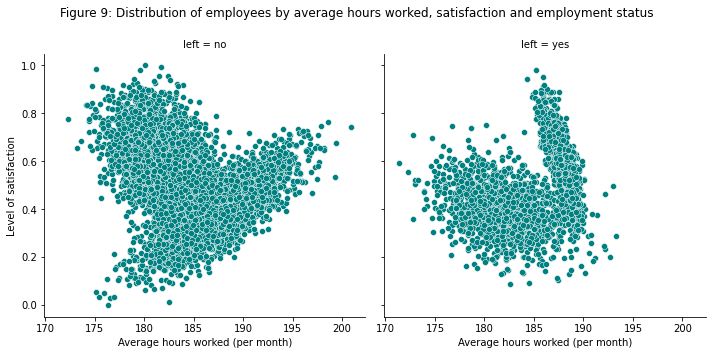

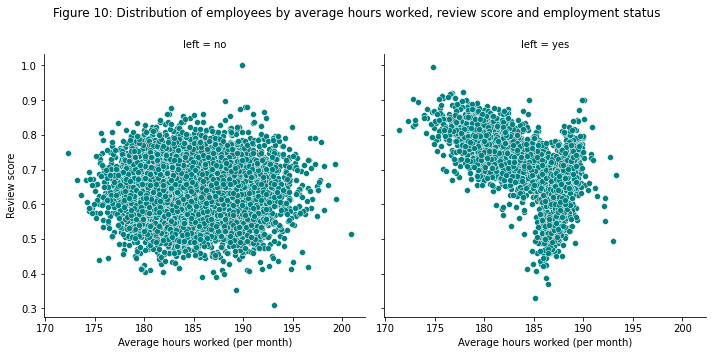

In [11]:
sr = sns.FacetGrid(data, col="left", height=5, aspect=1)
sr.map_dataframe(sns.scatterplot, x="satisfaction", y="review", color="teal")
sr.set_axis_labels("Level of satisfaction", "Review score")
sr.fig.subplots_adjust(top=0.85)
sr.fig.suptitle("Figure 8: Distribution of employees by satisfaction, review score and employment status");

ws = sns.FacetGrid(data, col="left", height=5, aspect=1)
ws.map_dataframe(sns.scatterplot, x="avg_hrs_month", y="satisfaction", color="teal")
ws.set_axis_labels("Average hours worked (per month)", "Level of satisfaction")
ws.fig.subplots_adjust(top=0.85)
ws.fig.suptitle("Figure 9: Distribution of employees by average hours worked, satisfaction and employment status");

wr = sns.FacetGrid(data, col="left", height=5, aspect=1)
wr.map_dataframe(sns.scatterplot, x="avg_hrs_month", y="review", color="teal")
wr.set_axis_labels("Average hours worked (per month)", "Review score")
wr.fig.subplots_adjust(top=0.85)
wr.fig.suptitle("Figure 10: Distribution of employees by average hours worked, review score and employment status");

Finally, Figures 11 and 12 display the distribution and average review scores and level of employee satisfaction by length of tenure and employment status, which both confirmed previous findings. Review scores were generally higher for employees had left, but interestingly declined over time until seven years of tenure, at which point they stabilised to about the same average level as those that had stayed. Average levels of satisfaction generally also declined over time, but suddenly jumped at that same point (seven years) before dropping again in the ninth year of tenure. Earlier it had been observed that turnover also rose again in the seventh and eighth years of tenure, so perhaps the group of employees about to depart was causing this uncharacteristic jump?

Additional bivariate charts that could be of interest but not central to the main report can be found in Appendix B, such as distributions of review scores and satisfaction by department and proportions of employees who left after not receiving a promotion by salary tier.

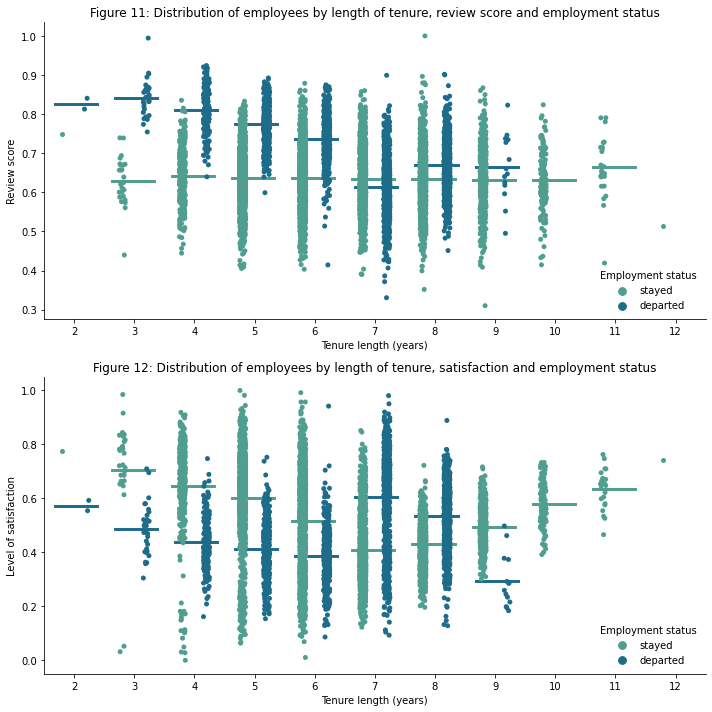

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))

tr = sns.stripplot(x="tenure", y="review", hue="left", data=data, dodge=True, palette="crest", ax=axs[0])
sns.pointplot(x="tenure", y="review", hue="left", data=data, join=False, dodge=True, 
              palette="crest", ci=0, capsize=0.7, scale=0, ax=axs[0])
tr.set(xlabel="Tenure length (years)", ylabel="Review score")
tr.set_title("Figure 11: Distribution of employees by length of tenure, review score and employment status")

handles, labels = tr.get_legend_handles_labels()
axs[0].legend(handles[0:2], ["stayed", "departed"], title="Employment status", 
              loc="lower right", frameon=False)

ts = sns.stripplot(x="tenure", y="satisfaction", hue="left", data=data, dodge=True, 
                   palette="crest", ax=axs[1])
sns.pointplot(x="tenure", y="satisfaction", hue="left", data=data, join=False, dodge=True, 
              palette="crest", ci=0, capsize=0.7, scale=0, ax=axs[1])
ts.set(xlabel="Tenure length (years)", ylabel="Level of satisfaction")
ts.set_title("Figure 12: Distribution of employees by length of tenure, satisfaction and employment status")

handles, labels = ts.get_legend_handles_labels()
axs[1].legend(handles[0:2], ["stayed", "departed"], title="Employment status", 
              loc="lower right", frameon=False)

fig.tight_layout()
sns.despine();

In [13]:
# define the four clusters and add them to the dataset
data['justajob'] = data.apply(lambda x: "yes" if (x.satisfaction <= 0.6 and x.avg_hrs_month <= 186) or 
                              (x.satisfaction <= 0.5 and x.avg_hrs_month <= 187) or
                              (x.satisfaction <= 0.4 and x.avg_hrs_month <= 187.5) else "no", axis=1)

data['longerhours'] = data.apply(lambda x: "yes" if (x.review <= 0.6 and x.avg_hrs_month > 184) or 
                                 (x.avg_hrs_month >= 186.5) else "no", axis=1)

# add two extra features corresponding to tenure length
data['seveneightyears'] = data.apply(lambda x: "yes" if (x.tenure == 7 or x.tenure == 8) else "no", axis=1)
data['twothreeyears'] = data.apply(lambda x: "yes" if (x.tenure == 2 or x.tenure == 3) else "no", axis=1)

# could also consider dropping avg_hrs_month or tenure at this stage due to their very high correlation (multicollinearity), but won't at this stage.

### Candidate classifiers

In [14]:
# split target column from features
X = data.drop('left', axis=1)
y = data.left

# instantiate the label encoder and transform the y column
y_enc = LabelEncoder().fit_transform(y)
y_enc = pd.Series(y_enc).astype('category')
y_enc.rename('left', inplace=True);

In [15]:
# identify the categorical feature indices
# convert tenure and number of projects to floats
X.projects = X.projects.astype('float')
X.tenure = X.tenure.astype('float')

# convert all categorical-type features to objects (required for catboost Pool object)
category_vars = ['department', 'promoted', 'salary', 'bonus', 'justajob', 
                 'longerhours', 'seveneightyears', 'twothreeyears']
X[category_vars] = X[category_vars].apply(lambda x: x.astype(object))

categorical_feature_indices = np.where(X.dtypes != float)[0]

# specify the categorical, ordinal and numeric features
cat_X = ['department', 'promoted', 'bonus', 'justajob', 'longerhours', 
         'seveneightyears', 'twothreeyears']
ord_X = ['salary']
num_X = ['projects', 'tenure', 'avg_hrs_month', 'satisfaction', 'review']

# specify salary label order
salary_order = ['low', 'medium', 'high']

# create the column transformers
categorical_encoder = OneHotEncoder()
categorical_encoder_logreg = OneHotEncoder(drop='first')
ordinal_encoder = OrdinalEncoder(categories=[salary_order])

rs_scaler = RobustScaler()
lr_rs_scaler = RobustScaler()

lr_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_encoder_logreg, cat_X),
        ("ord", ordinal_encoder, ord_X)],
    remainder='passthrough',
    verbose=False
)

model_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_encoder, cat_X),
        ("ord", ordinal_encoder, ord_X)],
    remainder='passthrough',
    verbose=False
)

# initialise the classifiers with (largely) default hyperparameters
ab = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3, class_weight="balanced"), random_state=22)
cb = CatBoostClassifier(class_weights=[0.29, 0.71], random_state=22)
dt = DecisionTreeClassifier(class_weight="balanced", random_state=22)
ext = ExtraTreesClassifier(class_weight="balanced_subsample", oob_score=True, bootstrap=True, random_state=22)
gb = GradientBoostingClassifier(random_state=22)
knn = KNeighborsClassifier()
lr = LogisticRegression(class_weight="balanced", random_state=22)
nb = GaussianNB()
rf = RandomForestClassifier(class_weight="balanced_subsample", oob_score=True, random_state=22)
sv = SVC(class_weight="balanced", probability=True, random_state=22)

# create the model and model name lists
classifiers = [ab, cb, dt, ext, gb, knn, lr, nb, rf, sv]
model_names = ["AdaBoost", "CatBoost", "ExtraTrees", "Decision Tree", "Gradient Boosting", "K-Nearest Neighbours", 
               "Logistic Regression", "Naive Bayes", "Random Forest", "Support Vector"]

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=22)
pool_train = Pool(X_train, y_train, cat_features=categorical_feature_indices)
pool_test = Pool(X_test, y_test, cat_features=categorical_feature_indices)

In [16]:
# fit the baseline models
pipelines = {model_names[0]: make_pipeline(model_preprocessor, classifiers[0]),
             model_names[1]: make_pipeline(classifiers[1]), # catboost
             model_names[2]: make_pipeline(model_preprocessor, classifiers[2]),
             model_names[3]: make_pipeline(model_preprocessor, classifiers[3]),
             model_names[4]: make_pipeline(model_preprocessor, classifiers[4]),
             model_names[5]: make_pipeline(model_preprocessor, rs_scaler, classifiers[5]), # knn
             model_names[6]: make_pipeline(lr_preprocessor, lr_rs_scaler, classifiers[6]), # lr
             model_names[7]: make_pipeline(model_preprocessor, classifiers[7]),
             model_names[8]: make_pipeline(model_preprocessor, classifiers[8]),
             model_names[9]: make_pipeline(model_preprocessor, rs_scaler, classifiers[9])} # sv

baseline_models = {}
for name, pipeline in pipelines.items():
    if name == "CatBoost":
        #pipeline.fit(X_train, y_train, catboostclassifier__cat_features=categorical_feature_indices, catboostclassifier__verbose=False)
        pipeline.fit(pool_train, catboostclassifier__verbose=False)
    else:
        pipeline.fit(X_train, y_train)
    baseline_models[name] = pipeline

In [17]:
# create function to extract all desired classification performance metrics
def get_perf_metrics(pipeline_dict):
    train_accs = []
    train_f1s = []
    train_roc_aucs = []
    train_pr_aucs = []
    train_precs = []
    train_recs = []
    train_specs = []
    train_fprs_list = []
    train_fnrs_list = []

    test_accs = []
    test_f1s = []
    test_roc_aucs = []
    test_pr_aucs = []
    test_precs = []
    test_recs = []
    test_specs = []
    test_fprs_list = []
    test_fnrs_list = []

    train_fprss = []
    train_tprss = []
    test_fprss = []
    test_tprss = []
    train_precisionss = []
    train_recallss = []
    test_precisionss = []
    test_recallss = []

    for name, pipe in pipeline_dict.items():
        y_pred_test = pipe.predict(X_test)
        y_pred_train = pipe.predict(X_train)

        y_probs_test = pipe.predict_proba(X_test)[:,1]
        y_probs_train = pipe.predict_proba(X_train)[:,1]

        train_precisions, train_recalls, _ = metrics.precision_recall_curve(y_train, y_probs_train)
        test_precisions, test_recalls, _ = metrics.precision_recall_curve(y_test, y_probs_test)

        train_fprs, train_tprs, _ = metrics.roc_curve(y_train, y_probs_train)
        test_fprs, test_tprs, _ = metrics.roc_curve(y_test, y_probs_test)

        tn_train, fp_train, fn_train, tp_train = metrics.confusion_matrix(y_train, y_pred_train).ravel()
        tn_test, fp_test, fn_test, tp_test = metrics.confusion_matrix(y_test, y_pred_test).ravel()

        # save the performance metrics
        train_accs.append(metrics.accuracy_score(y_train, y_pred_train))
        train_f1s.append(metrics.f1_score(y_train, y_pred_train))
        train_roc_aucs.append(metrics.roc_auc_score(y_train, y_probs_train))
        train_pr_aucs.append(metrics.auc(train_recalls, train_precisions))
        train_precs.append(metrics.precision_score(y_train, y_pred_train))
        train_recs.append(metrics.recall_score(y_train, y_pred_train))
        train_specs.append(tn_train / (tn_train + fp_train))
        train_fprs_list.append(fp_train / (fp_train + tn_train))
        train_fnrs_list.append(fn_train / (fn_train + tp_train))    

        test_accs.append(metrics.accuracy_score(y_test, y_pred_test))
        test_f1s.append(metrics.f1_score(y_test, y_pred_test))
        test_roc_aucs.append(metrics.roc_auc_score(y_test, y_probs_test))
        test_pr_aucs.append(metrics.auc(test_recalls, test_precisions))
        test_precs.append(metrics.precision_score(y_test, y_pred_test))
        test_recs.append(metrics.recall_score(y_test, y_pred_test))
        test_specs.append(tn_test / (tn_test + fp_test))
        test_fprs_list.append(fp_test / (fp_test + tn_test))
        test_fnrs_list.append(fn_test / (fn_test + tp_test))

        train_fprss.append(train_fprs)
        train_tprss.append(train_tprs)
        test_fprss.append(test_fprs)
        test_tprss.append(test_tprs)
        train_precisionss.append(train_precisions)
        train_recallss.append(train_recalls)
        test_precisionss.append(test_precisions)
        test_recallss.append(test_recalls)
    
    # aggregate the performance metric lists into seperate dataframes
    train_perf_metrics = pd.DataFrame(
        {'model': model_names,
         'accuracy': train_accs,
         'f1 score': train_f1s,
         'roc auc': train_roc_aucs,
         'pr auc': train_pr_aucs,
         'precision': train_precs,
         'recall': train_recs,
         'specificity': train_specs,
         'false positive rate': train_fprs_list,
         'false negative rate': train_fnrs_list})

    test_perf_metrics = pd.DataFrame(
        {'model': model_names,
         'accuracy': test_accs,
         'f1 score': test_f1s,
         'roc auc': test_roc_aucs,
         'pr auc': test_pr_aucs,
         'precision': test_precs,
         'recall': test_recs,
         'specificity': test_specs,
         'false positive rate': test_fprs_list,
         'false negative rate': test_fnrs_list})
    
    metric_obs = namedtuple("metric_obs", ["train_perf_metrics", "test_perf_metrics", 
                                           "train_fprss", "test_fprss",
                                           "train_tprss", "test_tprss",
                                           "train_precisionss", "train_recallss",
                                           "test_precisionss", "test_recallss"])

    # need the latter eight for auc curve plotting
    return metric_obs(
        train_perf_metrics, test_perf_metrics, 
        train_fprss, test_fprss, 
        train_tprss, test_tprss, 
        train_precisionss, train_recallss, 
        test_precisionss, test_recallss)

# call the function
baseline_metric_obs = get_perf_metrics(pipeline_dict=baseline_models)

In [18]:
# create the base rate model
# recall that it just predicts the majority class 100% of the time
def base_rate_model(X):
    y = np.zeros(X.shape[0])
    return y

# assess its performance
y_pred_train = base_rate_model(X_train)
y_pred_test = base_rate_model(X_test)

tn_train, fp_train, fn_train, tp_train = metrics.confusion_matrix(y_train, y_pred_train).ravel()
tn_test, fp_test, fn_test, tp_test = metrics.confusion_matrix(y_test, y_pred_test).ravel()

base_row_train = pd.Series(['Base Rate', 
                            metrics.accuracy_score(y_train, y_pred_train), 
                            metrics.f1_score(y_train, y_pred_train), 
                            0.5, 
                            0, 
                            metrics.precision_score(y_train, y_pred_train),  
                            metrics.recall_score(y_train, y_pred_train), 
                            tn_train / (tn_train + fp_train),
                            fp_train / (fp_train + tn_train),
                            fn_train / (fn_train + tp_train)], index=baseline_metric_obs.train_perf_metrics.columns)

base_row_test = pd.Series(['Base Rate', 
                            metrics.accuracy_score(y_test, y_pred_test), 
                            metrics.f1_score(y_test, y_pred_test), 
                            0.5, 
                            0, 
                            metrics.precision_score(y_test, y_pred_test),  
                            metrics.recall_score(y_test, y_pred_test), 
                            tn_test / (tn_test + fp_test),
                            fp_test / (fp_test + tn_test),
                            fn_test / (fn_test + tp_test)], index=baseline_metric_obs.test_perf_metrics.columns)

# add the base rate model metrics
train_baseline_perf_metrics = baseline_metric_obs.train_perf_metrics.append(base_row_train, ignore_index=True)
test_baseline_perf_metrics = baseline_metric_obs.test_perf_metrics.append(base_row_test, ignore_index=True)

Whilst there was some disagreement across the different metrics, and it was evident that there was overfitting occurring in the decision tree algorithms (Table 1 and Table C.1), the five models shortlisted for hyperparameter tuning were: CatBoost, Random Forest, Gradient Boosting, AdaBoost and Decision Tree.

Figure 13 (and Figure C.1 in the Appendix) also demonstrate that although all models performed better than the base rate, the worst performing models with respect to the AUROC and AUPRC metrics were consistently Naive Bayes and Logistic Regression.

In [19]:
print("Table 1: Baseline model performance metrics on the test data")
test_baseline_perf_metrics.sort_values(by=['f1 score'], ascending=False)

Table 1: Baseline model performance metrics on the test data


model  accuracy  f1 score   roc auc    pr auc  precision  \
1               CatBoost  0.859539  0.778878  0.938165  0.877899   0.720611   
4      Gradient Boosting  0.861635  0.744186  0.924324  0.854160   0.808421   
8          Random Forest  0.862683  0.744141  0.923541  0.854415   0.815846   
0               AdaBoost  0.832285  0.739414  0.904710  0.800803   0.676602   
3          Decision Tree  0.848532  0.719690  0.908882  0.831435   0.782700   
9         Support Vector  0.808700  0.715511  0.897689  0.775520   0.632231   
2             ExtraTrees  0.820231  0.692927  0.783370  0.737482   0.691071   
5   K-Nearest Neighbours  0.804507  0.636806  0.850819  0.726646   0.695745   
6    Logistic Regression  0.727463  0.617084  0.795723  0.564596   0.523096   
7            Naive Bayes  0.680294  0.368530  0.710918  0.429541   0.435208   
10             Base Rate  0.708071  0.000000  0.500000  0.000000   0.000000   

      recall  specificity  false positive rate  false negative rate  
1   0.847397     0.864545             0.135455             0.152603  
4   0.689408     0.932642             0.067358             0.310592  
8   0.684022     0.936343             0.063657             0.315978  
0   0.815081     0.839378             0.160622             0.184919  
3   0.666068     0.923760             0.076240             0.333932  
9   0.824057     0.802369             0.197631             0.175943  
2   0.694794     0.871947             0.128053             0.305206  
5   0.587074     0.894152             0.105848             0.412926  
6   0.752244     0.717246             0.282754             0.247756  
7   0.319569     0.829016             0.170984             0.680431  
10  0.000000     1.000000             0.000000             1.000000

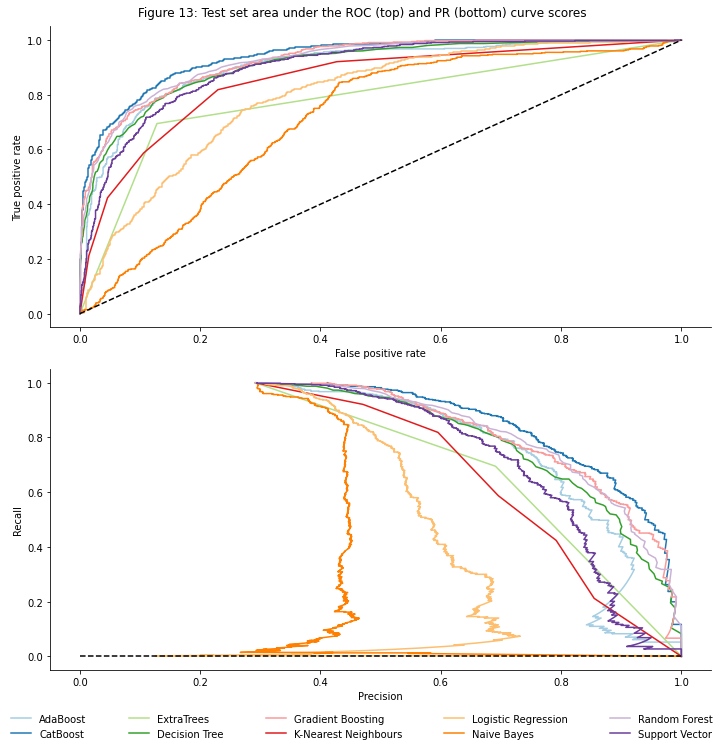

In [20]:
# set the colour scheme
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Paired.colors)

# create a function to plot the roc auc and pr auc curves
def plot_roc_pr_auc_curves(data_subset, fpr_data, tpr_data, precision_data, recall_data, fignum):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))

    for i in range(len(fpr_data)):
        ax1.plot(fpr_data[i], tpr_data[i], label=model_names[i])
    ax1.plot([0,1], [0,1], linestyle='--', label='Base rate', color='black')
    ax1.set(xlabel='False positive rate', ylabel='True positive rate')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)

    for i in range(len(precision_data)):
        ax2.plot(precision_data[i], recall_data[i], label=model_names[i])
    ax2.plot([0,1], [0,0], linestyle='--', label='Base rate', color='black')
    ax2.set(xlabel='Precision', ylabel='Recall')
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    
    fig.legend(model_names, loc="lower center", bbox_to_anchor=(0, -0.05, 1, 0.5), mode="expand", ncol=5, 
               frameon=False)
    fig.suptitle('Figure %s: %s set area under the ROC (top) and PR (bottom) curve scores' % (fignum, data_subset))
    fig.tight_layout();

# call the function on the test data
plot_roc_pr_auc_curves(data_subset='Test', 
                       fpr_data=baseline_metric_obs.test_fprss, 
                       tpr_data=baseline_metric_obs.test_tprss,
                       precision_data=baseline_metric_obs.test_precisionss, 
                       recall_data=baseline_metric_obs.test_recallss, 
                       fignum='13')

# reset rcparams to the default settings
plt.rcParams.update(mpl.rcParamsDefault)

### Hyperparameter tuning and final model selection

In [21]:
# time the tuning process
tune_start = time.time()

# define the smaller set of model pipelines
classifiers = [ab, cb, dt, gb, rf]
model_names = ["AdaBoost", "CatBoost", "Decision Tree", "Gradient Boosting", "Random Forest"]

pipelines = {model_names[0]: make_pipeline(model_preprocessor, classifiers[0]),
             model_names[1]: make_pipeline(classifiers[1]), # catboost
             model_names[2]: make_pipeline(model_preprocessor, classifiers[2]),
             model_names[3]: make_pipeline(model_preprocessor, classifiers[3]),
             model_names[4]: make_pipeline(model_preprocessor, classifiers[4])}

# define the hyperparameter search space
ab_hyperparams = {'adaboostclassifier__n_estimators': [int(x) for x in range(50, 250, 50)],
                  'adaboostclassifier__learning_rate': [0.001, 0.01, 0.1, 1]}

cb_hyperparams = {'catboostclassifier__depth': [4, 6, 8, 10],
                  'catboostclassifier__iterations': [int(x) for x in range(400, 1100, 200)]}
                  
dt_hyperparams = {'decisiontreeclassifier__max_depth': [1, 3, 5],
                  'decisiontreeclassifier__min_samples_leaf': [1, 3, 5, 10]}

gb_hyperparams = {'gradientboostingclassifier__n_estimators': [int(x) for x in range(100, 800, 200)],
                  'gradientboostingclassifier__learning_rate': [0.001, 0.01, 0.1, 1],
                  'gradientboostingclassifier__max_depth': [1, 3, 5]}

rf_hyperparams = {'randomforestclassifier__n_estimators': [int(x) for x in range(100, 800, 200)],
                  'randomforestclassifier__max_features': ['auto', 'sqrt'],
                  'randomforestclassifier__min_samples_leaf': [1, 3, 5, 10]}

# save it in a dictionary
hyperparameters = {
    model_names[0]: ab_hyperparams,
    model_names[1]: cb_hyperparams,
    model_names[2]: dt_hyperparams,
    model_names[3]: gb_hyperparams,
    model_names[4]: rf_hyperparams}

# initialise a 5-fold stratified cross-validator
stratified_kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=22)

# fit and tune the models
tuned_models = {}
for name, pipeline in pipelines.items():
    hp_search = GridSearchCV(estimator=pipeline,
                             param_grid=hyperparameters[name],
                             scoring='f1',
                             cv=stratified_kfold,
                             refit=True,
                             verbose=False,
                             return_train_score=True,
                             n_jobs=-1)
    
    if name == "CatBoost":
        hp_search.fit(X_train, y_train, catboostclassifier__cat_features=categorical_feature_indices, catboostclassifier__verbose=False)
        #hp_search.fit(pool_train, catboostclassifier__verbose=False)
    else:
        hp_search.fit(X_train, y_train)
    tuned_models[name] = hp_search
    
tune_end = time.time()

In [22]:
total_tune_time = (tune_end - tune_start) / 60
#print("Total tuning time in minutes: %.2f" % total_tune_time)

In [23]:
# collate the cross validation results
cv_results = []
cv_estimators = []
cv_scores = []
cv_params_list = []

for name, model in tuned_models.items():
    cv_results = model.cv_results_ # dict with keys as column headers and values as columns
    cv_estimator = model.best_estimator_ # estimator chosen by search
    cv_score = model.best_score_ # mean cv score of the best_estimator (i.e. avg holdout perf across the 5 folds)
    cv_params = model.best_params_ # parameter setting that gave the best results on the hold out data.
    
    # save the model objects
    cv_estimators.append(cv_estimator)
    cv_scores.append(cv_score)
    cv_params_list.append(cv_params)

# call the metric extraction function
tuned_metric_obs = get_perf_metrics(pipeline_dict=tuned_models)

The final algorithm chosen was CatBoost with:

- an Area Under the Precision Recall Curve (AUPRC) of 87.5%,
- an Area Under the Receiver Operating Characteristic Curve (AUROC) score of 93.7%, 
- an F1 score of 77.7%, and
- recall of 84.6% on the test data (Table 2).

In other words, it meant that the chosen algorithm had an 87.5% to 93.7% chance (depending on the choice of metric) of disguishing between an employee who stayed and one who departed and was able to correctly classify 84.6% of the employees that had departed.

Furthermore, as shown in Figure 15, out of the 1,908 employees in the test set, the algorithm:

- correctly classified 471 departed employees (True Positives) whilst getting 185 wrong (Type I errors), and
- correctly classified 1,166 employed employees (True Negatives) whilst getting 86 wrong (Type II errors).

In [24]:
print("Table 2: Tuned model performance metrics on the test data")
test_tuned_perf_metrics = tuned_metric_obs.test_perf_metrics
test_tuned_perf_metrics.sort_values(by=['f1 score'], ascending=False)

Table 2: Tuned model performance metrics on the test data


model  accuracy  f1 score   roc auc    pr auc  precision  \
1           CatBoost  0.857966  0.776587  0.936623  0.875084   0.717988   
4      Random Forest  0.861635  0.768421  0.928491  0.864504   0.751286   
3  Gradient Boosting  0.871593  0.764196  0.932615  0.863369   0.823651   
0           AdaBoost  0.825996  0.734824  0.917972  0.842780   0.661871   
2      Decision Tree  0.786164  0.702190  0.897131  0.797473   0.591636   

     recall  specificity  false positive rate  false negative rate  
1  0.845601     0.863064             0.136936             0.154399  
4  0.786355     0.892672             0.107328             0.213645  
3  0.712747     0.937084             0.062916             0.287253  
0  0.825853     0.826055             0.173945             0.174147  
2  0.863555     0.754256             0.245744             0.136445

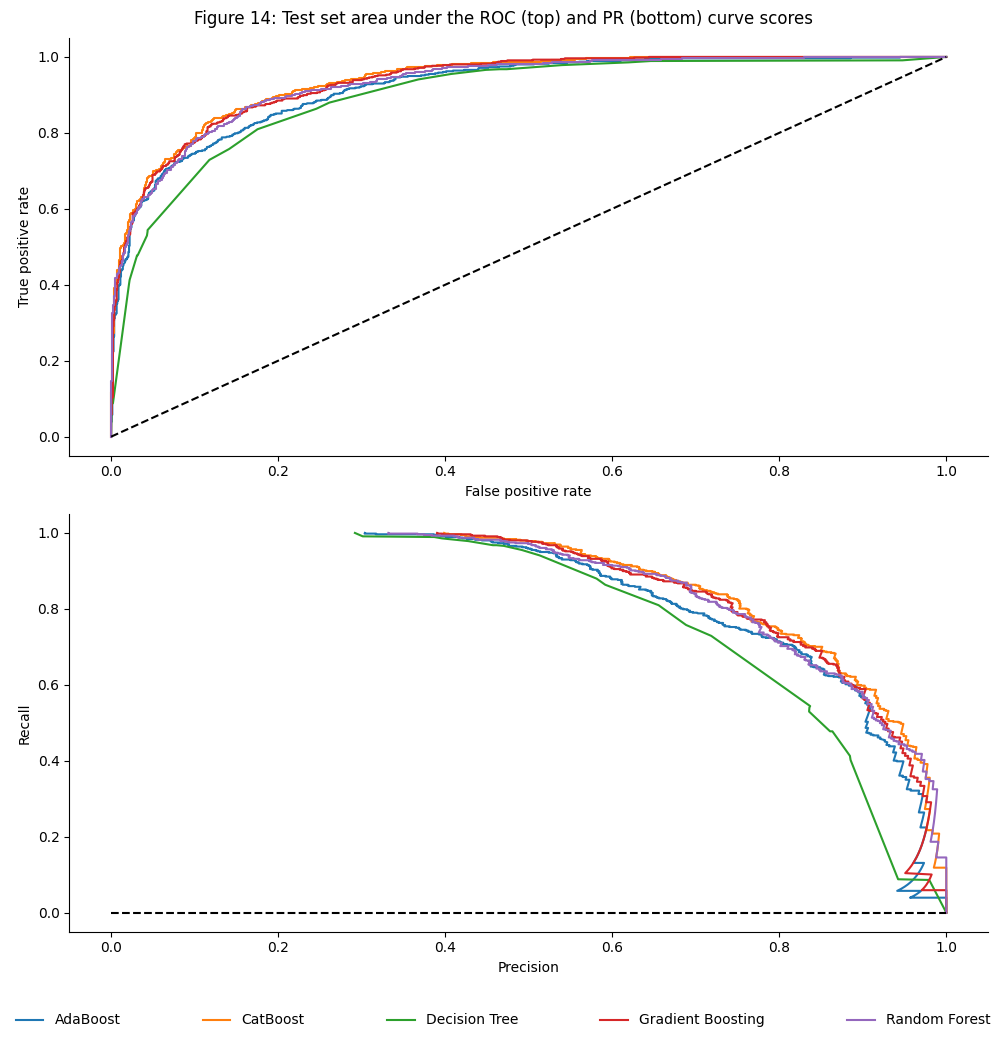

In [25]:
# call the plotting function
plot_roc_pr_auc_curves(data_subset='Test', 
                       fpr_data=tuned_metric_obs.test_fprss, 
                       tpr_data=tuned_metric_obs.test_tprss,
                       precision_data=tuned_metric_obs.test_precisionss, 
                       recall_data=tuned_metric_obs.test_recallss, 
                       fignum='14')

# reset rcparams to the default settings
plt.rcParams.update(mpl.rcParamsDefault)

Figure 15: Final model (CatBoost) confusion matrix for the test set


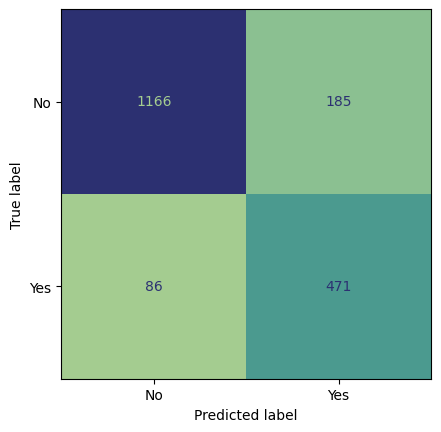

In [26]:
# confusion matrix for the chosen algorithm
final_model_name = list(tuned_models.keys())[1]
final_model = list(tuned_models.values())[1]

y_pred_test = final_model.predict(X_test)
y_pred_train = final_model.predict(X_train)

print(f"Figure 15: Final model ({final_model_name}) confusion matrix for the test set")
cm = metrics.confusion_matrix(y_test, y_pred_test)
cm_disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
cm_disp.plot(cmap='crest', colorbar=False);

### Feature importance

Table 5 displays the importance scores of all input features according to five different metrics, two of which are in-house metrics specific to the CatBoost algorithm and the final three are model agnostic (that is, they can be calculated for any algorithm)[^4]. Whilst the metrics were somewhat inconsistent as to the relative ranking of the features, they all agreed that the most important features for predicting whether or not an employee would depart was the average hours worked, employee satisfaction, an employee's review score and whether or not the employee was in their seventh or eighth year of tenure.

Furthermore, Figure 15, which displays the feature importances in Table 5 graphically, shows clearly that the CatBoost algorithm considered all but the top three or four features just about irrelevant to the model (and by extension, the most important factors associated with whether an employee was going to leave).


----------
[^4]: For more information about these metrics, please see the CatBooost *get_feature_importance*, sklearn *permutation_importance* and SHAP (SHapley Additive exPlanations) package documentation respectively.

[^5]: The CatBoost algorithm uses a variant on one-hot-encoding to internally transform any categorical or non-numeric features in a dataset to numerics. Furthermore, the creators strongly advise that the model be allowed to internally transform such features and not to pre-process them beforehand as is required for many machine learning algorithms.

In [27]:
final_model_name = list(baseline_models.keys())[1]
final_model = list(baseline_models.values())[1]['catboostclassifier']

pool_obj = Pool(X_test, y_test, cat_features=categorical_feature_indices)

# default importance: PredictionValuesChange for non-ranking metrics and LossFunctionChange for ranking metrics
#default_imp = final_model['catboostclassifier'].feature_importances_

# PredictionValuesChange: how much on average the prediction changes if the feature value changes. Higher values are better.
# Can give misleading results for ranking objectives as it may inflate the rank of groupwise features even if they have little influence on the resulting loss value
pred_values_change = final_model.get_feature_importance(pool_obj, type="PredictionValuesChange")

# LossFunctionChange: Takes the difference between the Loss function metric with and without the feature. Higher values are better.
# Computationally heavy but generally not misleading like PredictionValuesChange
loss_function_change = final_model.get_feature_importance(pool_obj, type="LossFunctionChange")

# Shap Values: impact of a feature on a single prediction value in comparison to the baseline prediction (mean of the target value for the training data)
shap_values = shap.explainers.Tree(final_model)(X_test)
# places more emphasis on broad average impact, and less on rare but high magnitude impacts
mean_shap_values = shap_values.abs.mean(0).values
# find features with high impacts for individual observations
max_shap_values = shap_values.abs.max(0).values # will highlight features with infrequent but high magnitude effects

# Permutation importance: Same concept as Shap but different implementation
perm_imp = permutation_importance(final_model, X_test, y_test, n_repeats=10, n_jobs=-1, random_state=22)['importances_mean']

importances_df = pd.DataFrame({
    'feature':  X_test.columns,
    #'feature importance': default_imp,
    'prediction values change': pred_values_change,
    'loss function change': loss_function_change * 100,
    'permutation importance': perm_imp * 100,
    'mean (absolute) shap value': mean_shap_values,
    'max (absolute) shap value': max_shap_values,
})

print("Table 5: CatBoost test set feature importance scores ordered by permutation score")
importances_df.sort_values(by=['permutation importance'], ascending=False)

Table 5: CatBoost test set feature importance scores ordered by permutation score


feature  prediction values change  loss function change  \
8     avg_hrs_month                 28.083153              7.719340   
6      satisfaction                 25.440007              3.941838   
2            review                 20.316531             10.259914   
11  seveneightyears                 13.795008              0.765984   
7             bonus                  0.749776             -0.019949   
3          projects                  1.364487             -0.087647   
12    twothreeyears                  0.013631              0.000497   
0        department                  2.088117             -0.048853   
5            tenure                  2.582681              0.127728   
1          promoted                  0.230688              0.023208   
4            salary                  0.825977              0.031880   
10      longerhours                  1.900665              0.266706   
9          justajob                  2.609280              0.275979   

    permutation importance  mean (absolute) shap value  \
8                11.892034                    0.939891   
6                11.671908                    0.602603   
2                 8.375262                    0.881241   
11                1.719078                    0.416458   
7                 0.146751                    0.032704   
3                 0.057652                    0.061602   
12                0.000000                    0.000480   
0                -0.036688                    0.054496   
5                -0.036688                    0.086575   
1                -0.047170                    0.029223   
4                -0.157233                    0.048531   
10               -0.440252                    0.110527   
9                -0.508386                    0.187171   

    max (absolute) shap value  
8                    3.443840  
6                    2.769659  
2                    4.408817  
11                   1.085138  
7                    0.294943  
3                    0.553380  
12                   0.048037  
0                    0.452491  
5                    0.432897  
1                    0.714034  
4                    0.226951  
10                   0.554436  
9                    0.414926

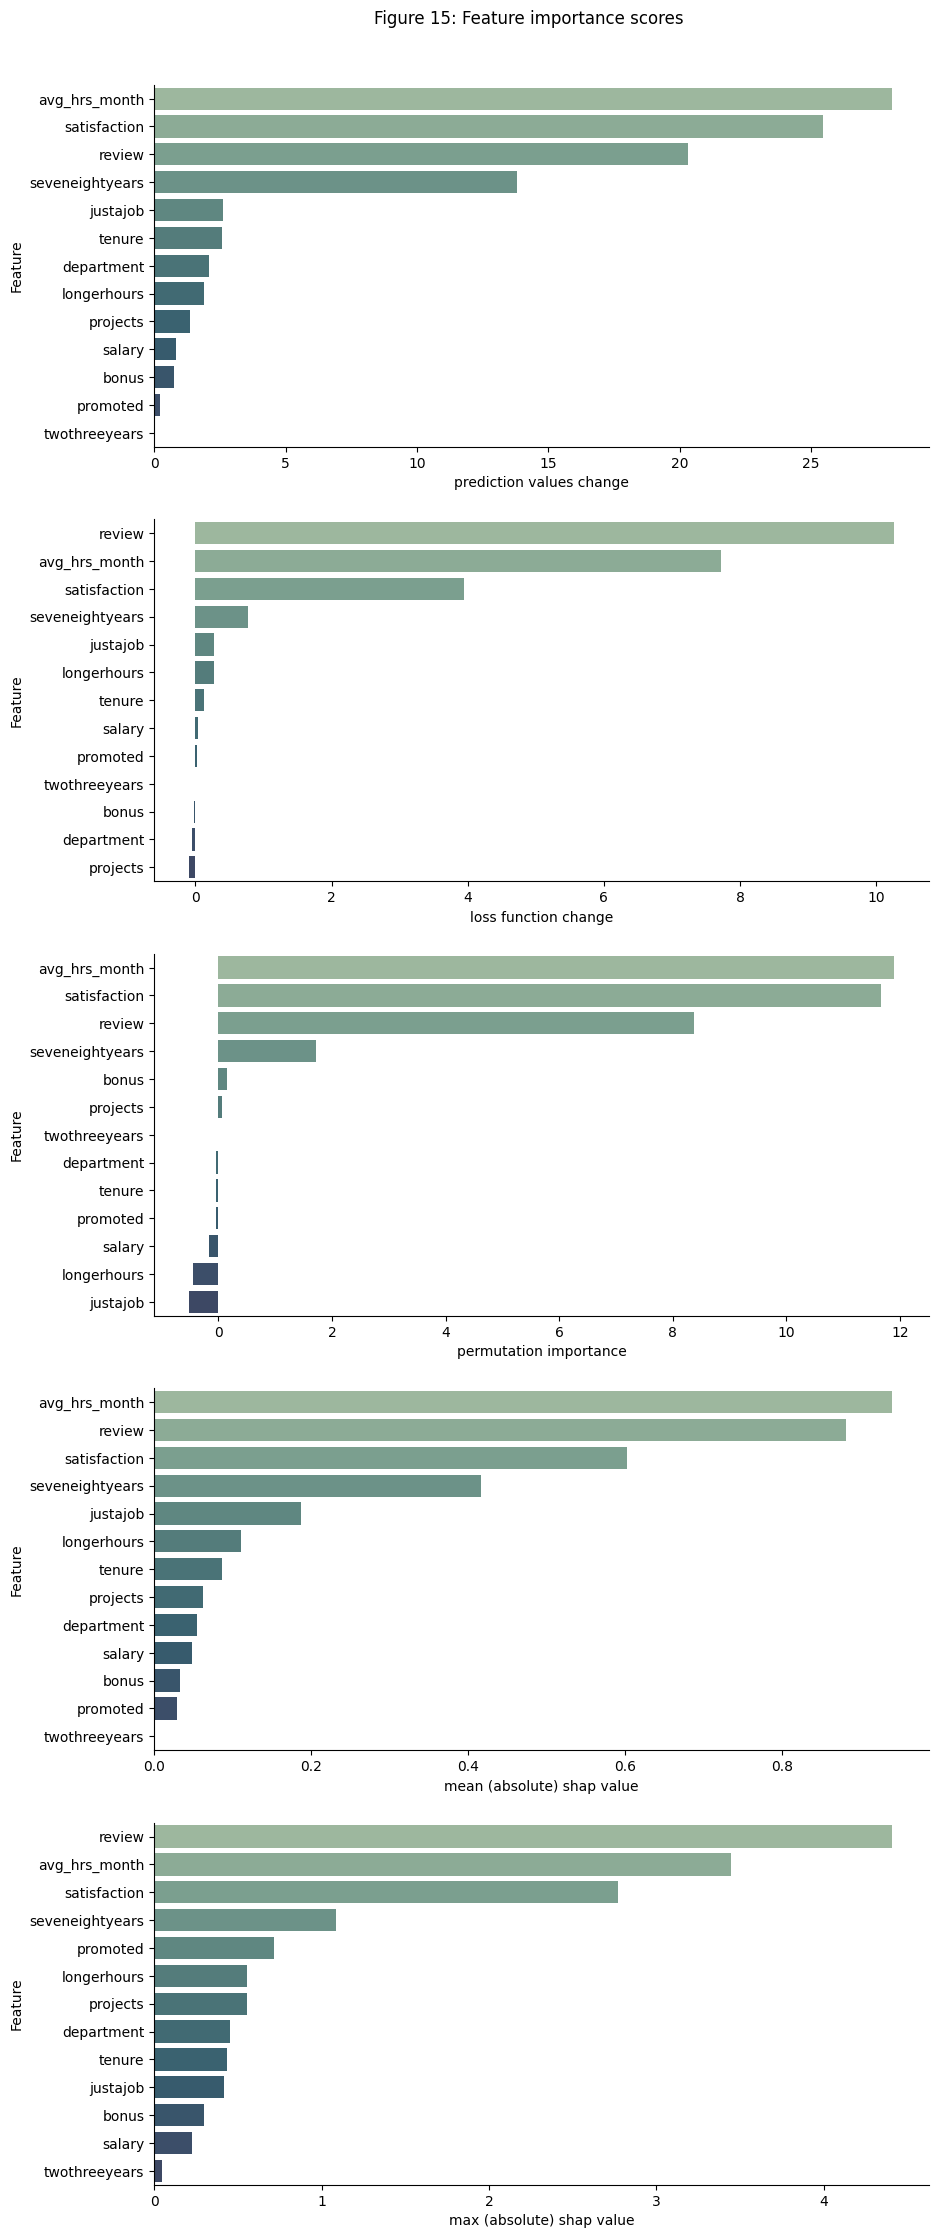

In [28]:
# plot each of the five metrics as a bar chart
importance_types = importances_df.columns[1:]

n = 1
fig = plt.subplots(figsize=(10,25))

for i in importance_types:
    plt.subplot(5, 1, n)
    fi = sns.barplot(y = 'feature', 
                     x = importances_df[i],
                     data = importances_df,
                     order = importances_df.sort_values(i, ascending=False).feature,
                     saturation = 0.5, 
                     palette = "crest")
    fi.set(ylabel="Feature")
    sns.despine()
    n += 1

plt.subplots_adjust(top=0.95)
plt.suptitle("Figure 15: Feature importance scores");

Figure 16 shows the SHAP (SHapley Additive exPlanations) values for each feature ordered by their mean absolute value. It indicated a complicated but mostly negative relationship between employee departure status and average monthly hours worked, a complicated by generally positive relationship between employee departure status and the level of employee satisfaction, a generally positive relationship between employee departure status and review score. The relationship for categorical variables was unknown.

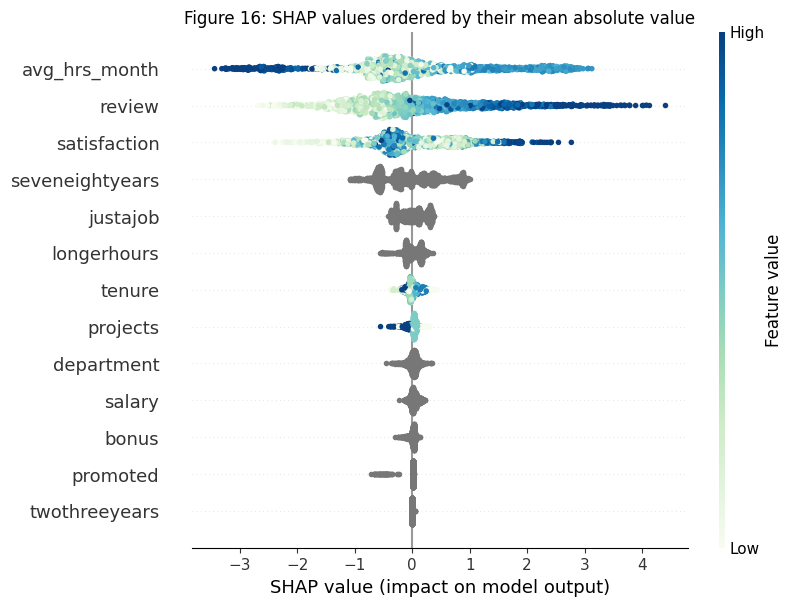

In [29]:
shap.plots.beeswarm(shap_values, max_display=13, color=plt.get_cmap("GnBu"), order=shap_values.abs.mean(0), show=False)
plt.title("Figure 16: SHAP values ordered by their mean absolute value");

Figure 17 provides some additional context and explanation for this observation, and also some insight into the relationship for the seventh or eighth year of tenure binary feature:
- average monthly hours worked up to about 185 hours had a slightly negative impact on class prediction, but average monthly hours worked between 185 and 190 hours had a positive impact. Anything over 190 hours had a more pronounced negative impact.
- there appeared to be two different contradicting relationships between level of satisfaction and class prediction. On the one hand, there was a positive relationship, which meant that as satisfaction increased, the probability of the positive class (that is, departure) also increased, but from about a level of 0.3, a secondary relationship emerged in which the probability of the positive class decreased as satisfaction increased.
- in general, as review score increased, the probability of the positive class increased.

The final feature, seveneightyears, can be interpreted as follows: overall, employees not in their seventh or eighth year of tenure had a negative impact on the model; that is, they were more likely to be predicted as the negative class. Employees in their seventh or eighth year were more likely to placed in the positive class.

Appendix D contains figures for the remaining features, both with and without the most probable interacting feature.

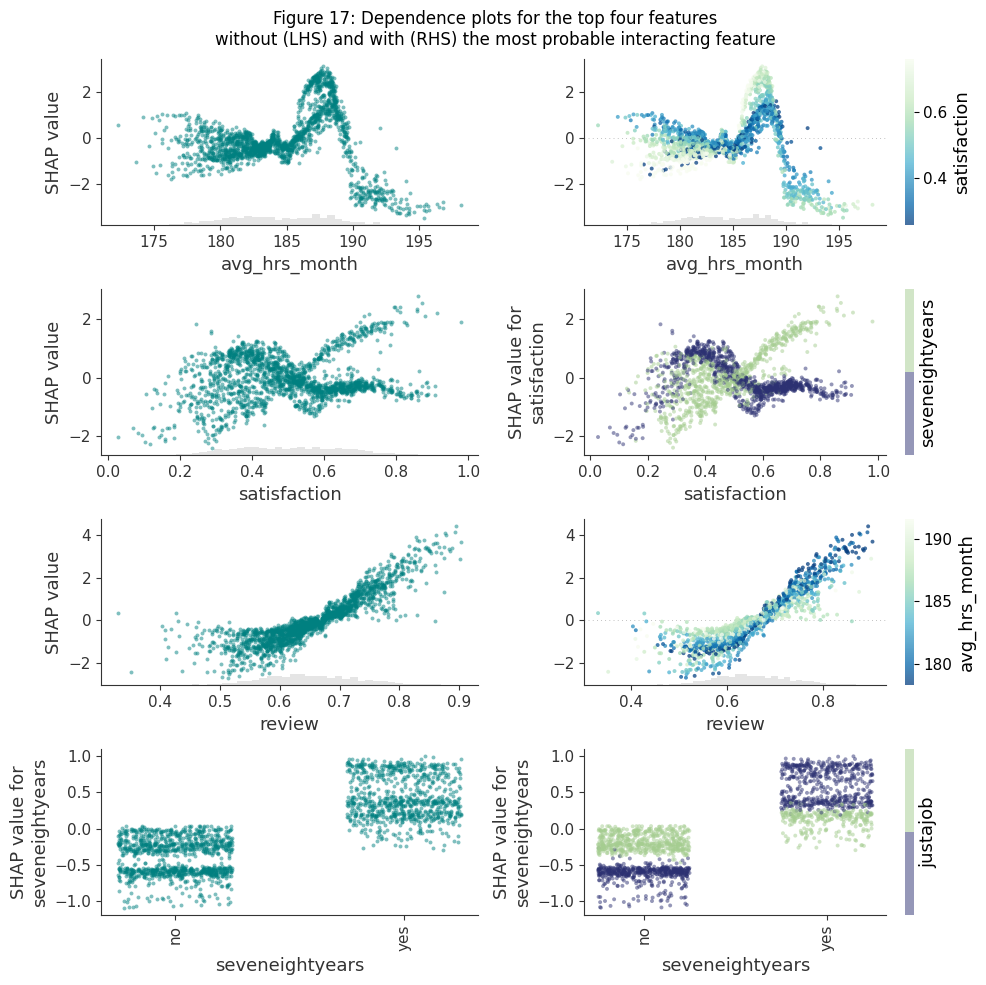

In [30]:
fig, axs = plt.subplots(4, 2, figsize=(10,10))

shap.plots.scatter(shap_values[:, shap_values.abs.mean(0).argsort[-1]], color="teal", alpha=0.5, 
                        dot_size=8, show=False, ax=axs[0,0])
plt.ylabel("SHAP value")

shap.plots.scatter(shap_values[:, shap_values.abs.mean(0).argsort[-3]], color="teal", alpha=0.5, 
                        dot_size=8, show=False, ax=axs[1,0])
plt.ylabel("SHAP value")

shap.plots.scatter(shap_values[:, shap_values.abs.mean(0).argsort[-2]], color="teal", alpha=0.5, 
                        dot_size=8, show=False, ax=axs[2,0])
plt.ylabel("SHAP value")

# different spec due to categorical feature
shap.dependence_plot("seveneightyears", shap_values.values, X_test, color="teal", alpha=0.5, 
                          ax=axs[3,0], show=False, interaction_index=None, x_jitter=0.5, dot_size=8)
plt.ylabel("SHAP value")

shap.plots.scatter(shap_values[:, shap_values.abs.mean(0).argsort[-1]], color=shap_values, 
                        cmap=plt.get_cmap("GnBu_r"), alpha=0.75, ax=axs[0,1], dot_size=8, show=False)
plt.ylabel(" ")

# different spec due to categorical feature
shap.dependence_plot("satisfaction", shap_values.values, X_test, cmap = plt.get_cmap("crest_r"), 
                          alpha=0.5, ax=axs[1,1], dot_size=8, show=False)
plt.ylabel(" ")

shap.plots.scatter(shap_values[:, shap_values.abs.mean(0).argsort[-2]], color=shap_values, 
                        cmap=plt.get_cmap("GnBu_r"), alpha=0.75, ax=axs[2,1], dot_size=8, show=False)
plt.ylabel(" ")

# different spec due to categorical feature
shap.dependence_plot("seveneightyears", shap_values.values, X_test, cmap = plt.get_cmap("crest_r"), 
                          alpha=0.5, ax=axs[3,1], show=False, x_jitter=0.5, dot_size=8)
plt.ylabel(" ")

fig.suptitle("Figure 17: Dependence plots for the top four features\nwithout (LHS) and with (RHS) the most probable interacting feature")
fig.tight_layout();

## Summary of Major Findings

**Feature-Target Analysis**

1. The average employee turnover rate was 29.2%, with the highest being observed in the IT department at 30.9% (closely followed by the Logistics department at 30.8%) and the lowest in the Finance department at 26.9%.
2. There were statistically significant relationships between an employee's departure status and whether or not the employee had received a promotion, their length of tenure, review score, and average hours worked per month.
3. At a 95% confidence level, there was no statistically signifant relationship found between departure status and whether or not the employee had received a bonus, their salary tier, the number of projects they had been involved in or their level of satisfaction.
4. The correlation analysis indicated that there was only a single weak positive linear relationship between departure status and review score.

**Feature-Feature Analysis**

5. The correlation analysis indicated a near perfect positive relationship between average hours worked per month and length of tenure. This indicated at least one could be dropped from any subsequent modelling of the relationship between departure status and the other features in the dataset.
6. The correlation analysis also suggested the presence of very weak negative linear relationships between:
- satisfaction and length of tenure
- satisfaction and average hours worked per month
- length of tenure and review score...
7. ...and weak negative linear relationships between:
- review score and satisfaction
- review score and average hours worked per month
8. When split out by departure status:
- the negative linear relationship between satisfaction and review score was present in both cohorts, although it appeared to be slightly stronger in those employees that had left
- there were two clusters of employees in both cohorts of satisfaction vs average hours worked, but in the cohort that had stayed, one cluster demonstrated a positive linear relationship.
- there appeared to be no relationship between review score and average hours worked for the employees that had stayed, but in the cohort of those that had left, there were two clusters, one of which again demonstrated a positive linear relationship.
- there appeared to be no relationship between length of tenure and average review score for the cohort that had stayed, but in the cohort that had left, average review score declined as length of tenure increased to a low point in the seventh year of tenure, before increasing slightly for the next two years.
- the average level of satisfaction was generally lower in the cohort who had departed than the cohort that had stayed, except for the seventh and eighth years of tenure.
- in both cohorts, the average level of satisfaction declined until the seventh year of tenure, upon which the average level of satisfaction began increasing again for the cohort that had stayed, but only temporarily increased for the cohort that had departed, before continuing on the downward trend in the ninth year.

**Modelling**

9. The chosen CatBoost algorithm, which had an 87.5% to 93.7% chance of distinguishing between the two employee cohorts, consistently identified average hours worked per month, review score, level of satisfaction, and whether or not the employee was in their seventh or eighth year of tenure as most important to predicting departure status across five different feature importance calculation methods.
10. The SHapley Additive exPlanations analysis, which assessed the impact each feature had on model predictions, indicated that there was generally a positive overall relationship from review score and satisfaction, and a mixed (but more negative than positive) relationship from average hours worked.
11. Subsequent dependence plot analysis confirmed or at least strongly suggested the presence of at least one or more features working together to influence the departure status predictions. For example, whether or not an employee was in their seventh or eighth year of tenure was found to have a strong influence on the SHAP values for average hours worked and level of satisfaction.

## Recommendations

Whilst there were no clear indications as to the source of the problem and hence the correct path for reducing turnover, it was recommended that:

1. Additional data be collected on characteristics such as employee age, gender, rank, employment type (full-time, part-time, contractor etc), family situation (single, young children etc) and distance of workplace from place of residence that might be able to explain some of the unexpected patterns observed in the current dataset.
2. Benchmark the organisation's turnover rate against the industry average in order to more accurately gauge the magnitude of the issue.
3. Perform a more in-depth analysis to understand some of the unexpected relationships such as the apparently negative one between review score and level of satisfaction.
4. Determine whether there is anything unique or different about employees entering their seventh or eighth year of tenure.
5. Explore ways of offering more career progression and promotion opportunities to employees.
6. Explore ways of boosting employee morale and organisational satisfaction. This may require an assessment and/or deliberate change in organisational culture.
7. Identify why employees are tending to leave with a high review score. Could it be correlated with something else?

## Appendix A: Target-feature statistical significance tests

In [31]:
# chi-squared tests of independence for the categorical features
cat_feats = ['department', 'salary', 'bonus', 'promoted', 'projects', 'tenure']
cat_desc = ['department', 'salary tier', 'bonus status', 'promotion status', 'number of projects', 'tenure length']

crosstabs = [pd.crosstab(data.left, data[feat]) for feat in cat_feats]

print("Chi-squared tests of independence results for the categorical features")
for ct, desc in zip(crosstabs, cat_desc):
    stat, p, dof, expected = chi2_contingency(ct)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably independent. There is insufficient evidence to suggest the presence of a relationship between turnover status and {}.'.format(desc))
    else:
        print('Probably dependent. There is insufficient evidence to suggest the presence of a relationship between turnover status and {}.'.format(desc))
    print('-----')

print('-----')


# Mann-Whitney U tests for the ordinal features
# this should be consistent with the chi-squared tests
dist1s = [data[data.left == "no"][feat] for feat in cat_feats[-2:]]
dist2s = [data[data.left == "yes"][feat] for feat in cat_feats[-2:]]

print("Mann-Whitney U test results for the ordinal features")
for dist1, dist2, desc in zip(dist1s, dist2s, cat_desc[-2:]):
    stat, p = mannwhitneyu(dist1, dist2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution. There is insufficient evidence to suggest the presence of a relationship between turnover status and {}.'.format(desc))
    else:
        print('Probably different distributions. There is evidence to suggest the presence of a relationship between turnover status and {}.'.format(desc))
    print('-----')
    
print('-----')


# Normality and Mann-Whitney U or Student's t-test results for the continuous features
cont_feats = ['review', 'satisfaction', 'avg_hrs_month']
cont_desc = ['review score', 'satisfaction score', 'average hours worked per month']

dist1s = [data[data.left == "no"][feat] for feat in cont_feats]
dist2s = [data[data.left == "yes"][feat] for feat in cont_feats]
dists = dist1s + dist2s

norm_results = []
for dist in dists:
    stat, p = shapiro(dist)
    if p > 0.05:
        result = "Probably Gaussian"
    else:
        result = 'Probably not Gaussian'
    norm_results.append(result)

print("Student's t-test/Mann-Whitney U test results for the continuous features")
for i, desc in zip(range(len(norm_results) // 2), cont_desc):
    if norm_results[i] == "Probably Gaussian" and norm_results[i+3] == "Probably Gaussian":
        print("Parametric test")
        stat, p = ttest_ind(dist1s[i], dist2s[i])
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            print('Probably the same distribution. There is insufficient evidence to suggest the presence of a relationship between turnover status and {}.'.format(desc))
        else:
            print('Probably different distributions. There is evidence to suggest the presence of a relationship between turnover status and {}.'.format(desc))
    else:
        print("Non-parametric test")
        stat, p = mannwhitneyu(dist1s[i], dist2s[i])
        print('stat=%.3f, p=%.3f' % (stat, p))
        if p > 0.05:
            print('Probably the same distribution. There is insufficient evidence to suggest the presence of a relationship between turnover status and {}.'.format(desc))
        else:
            print('Probably different distributions. There is evidence to suggest the presence of a relationship between turnover status and {}.'.format(desc))

    
    print('-----')

Chi-squared tests of independence results for the categorical features
stat=4.908, p=0.842
Probably independent. There is insufficient evidence to suggest the presence of a relationship between turnover status and department.
-----
stat=1.148, p=0.563
Probably independent. There is insufficient evidence to suggest the presence of a relationship between turnover status and salary tier.
-----
stat=1.197, p=0.274
Probably independent. There is insufficient evidence to suggest the presence of a relationship between turnover status and bonus status.
-----
stat=12.436, p=0.000
Probably dependent. There is insufficient evidence to suggest the presence of a relationship between turnover status and promotion status.
-----
stat=1.499, p=0.682
Probably independent. There is insufficient evidence to suggest the presence of a relationship between turnover status and number of projects.
-----
stat=660.286, p=0.000
Probably dependent. There is insufficient evidence to suggest the presence of a relati

## Appendix B: Additional bivariate EDA figures

Note that the horizonal lines denote the average for each unique x-y combination, and the legend is only repeated once for each row in the grid.

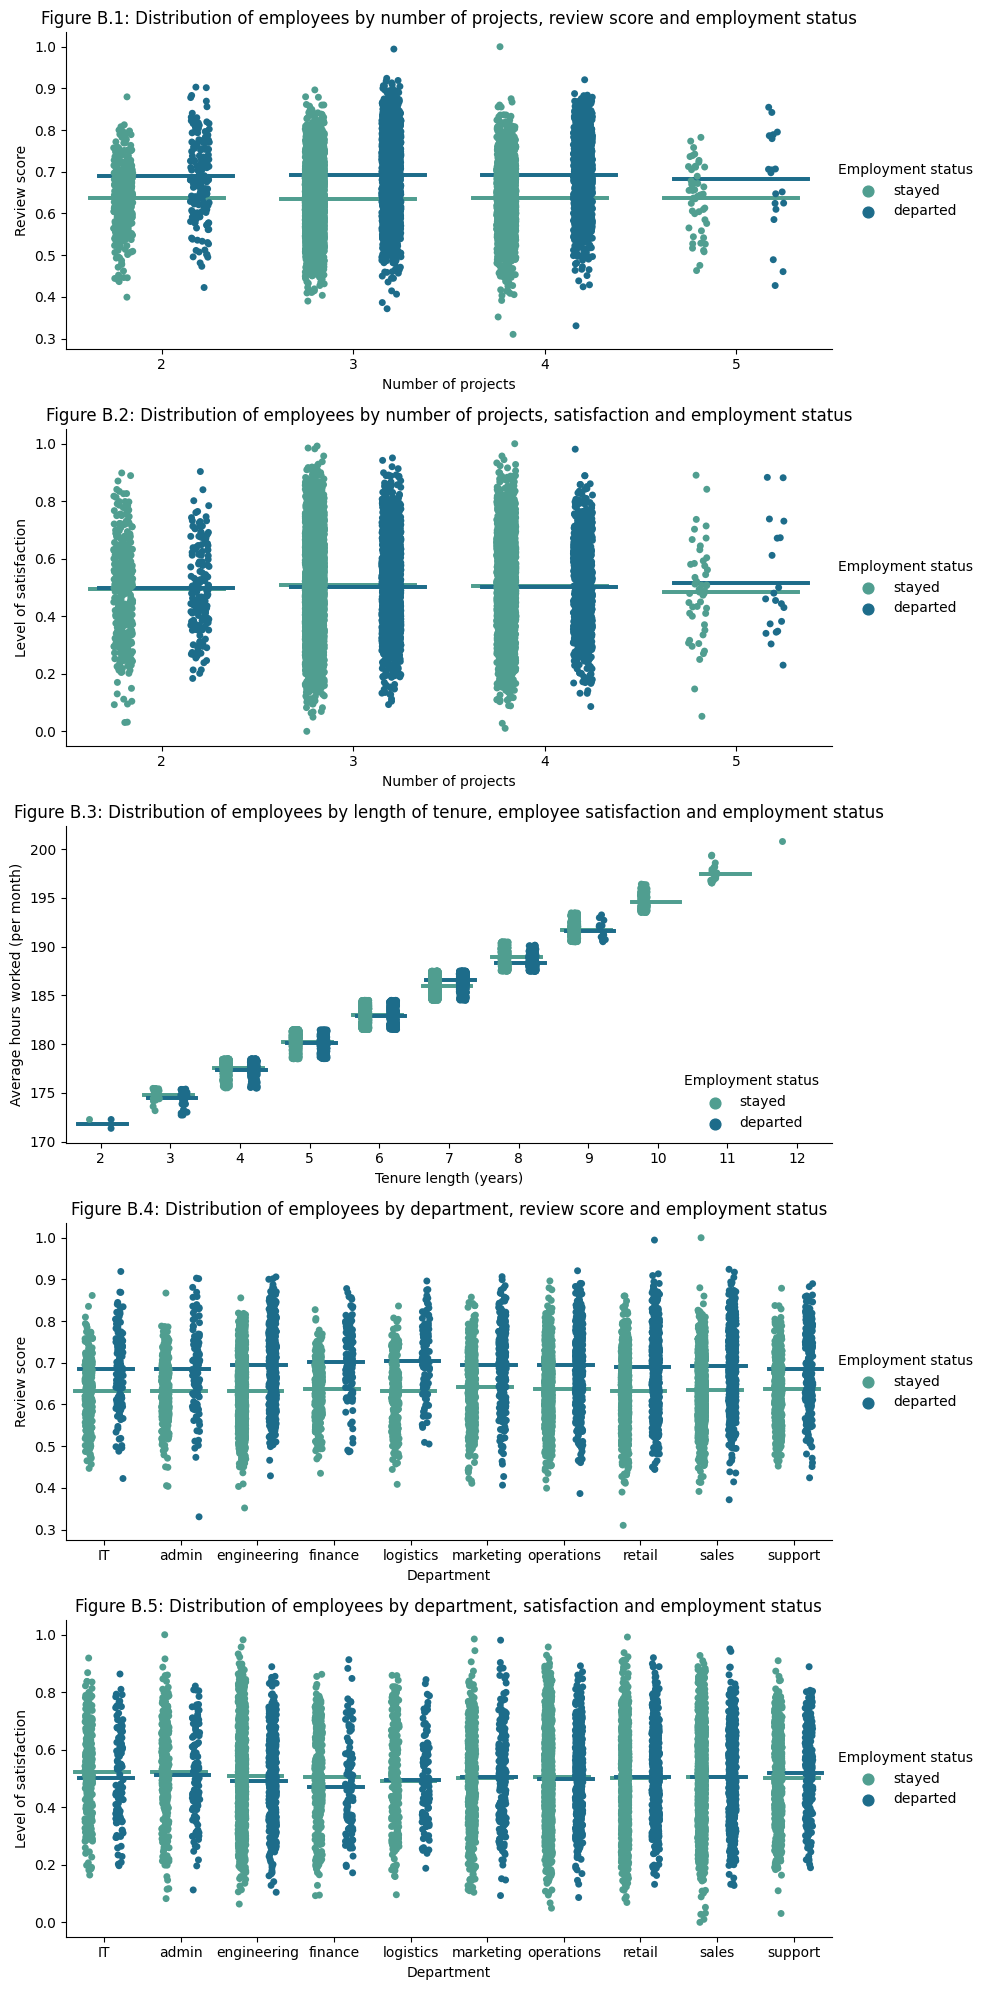

In [32]:
fig, axs = plt.subplots(5, 1, figsize=(10,20))

pr = sns.stripplot(x="projects", y="review", hue="left", data=data, dodge=True, palette="crest", 
                   ax=axs[0])
sns.pointplot(x="projects", y="review", hue="left", data=data, join=False, dodge=True, palette="crest", 
              ci=0, capsize=0.7, scale=0, ax=axs[0])
pr.set(xlabel="Number of projects", ylabel="Review score")
pr.set_title("Figure B.1: Distribution of employees by number of projects, review score and employment status")

handles, labels = pr.get_legend_handles_labels()
axs[0].legend(handles[0:2], ["stayed", "departed"], title="Employment status", loc="center right", 
              frameon=False, bbox_to_anchor=(1, 0.5, 0.2, 0))

ps = sns.stripplot(x="projects", y="satisfaction", hue="left", data=data, dodge=True, palette="crest", 
                   ax=axs[1])
sns.pointplot(x="projects", y="satisfaction", hue="left", data=data, join=False, dodge=True, 
              palette="crest", ci=0, capsize=0.7, scale=0, ax=axs[1])
ps.set(xlabel="Number of projects", ylabel="Level of satisfaction")
ps.set_title("Figure B.2: Distribution of employees by number of projects, satisfaction and employment status")

handles, labels = pr.get_legend_handles_labels()
axs[1].legend(handles[0:2], ["stayed", "departed"], title="Employment status", loc="center right", 
              frameon=False, bbox_to_anchor=(1, 0.5, 0.2, 0))

ta = sns.stripplot(x="tenure", y="avg_hrs_month", hue="left", data=data, dodge=True, jitter=True, 
                   palette="crest", ax=axs[2])
sns.pointplot(x="tenure", y="avg_hrs_month", hue="left", data=data, join=False, dodge=True, 
              palette="crest", ci=0, capsize=0.7, scale=0, ax=axs[2])
ta.set(xlabel="Tenure length (years)", ylabel="Average hours worked (per month)")
ta.set_title("Figure B.3: Distribution of employees by length of tenure, employee satisfaction and employment status")

handles, labels = pr.get_legend_handles_labels()
axs[2].legend(handles[0:2], ["stayed", "departed"], title="Employment status", loc="lower right", 
              frameon=False)

dr = sns.stripplot(x="department", y="review", hue="left", data=data, dodge=True, palette="crest", 
                   ax=axs[3])
sns.pointplot(x="department", y="review", hue="left", data=data, join=False, dodge=True, 
              palette="crest", ci=0, capsize=0.7, scale=0, ax=axs[3])
dr.set(xlabel="Department", ylabel="Review score")
dr.set_title("Figure B.4: Distribution of employees by department, review score and employment status")

handles, labels = pr.get_legend_handles_labels()
axs[3].legend(handles[0:2], ["stayed", "departed"], title="Employment status", loc="center right", 
              frameon=False, bbox_to_anchor=(1, 0.5, 0.2, 0))

ds = sns.stripplot(x="department", y="satisfaction", hue="left", data=data, dodge=True, palette="crest", 
                   ax=axs[4])
sns.pointplot(x="department", y="satisfaction", hue="left", data=data, join=False, dodge=True, 
              palette="crest", ci=0, capsize=0.7, scale=0, ax=axs[4])
ds.set(xlabel="Department", ylabel="Level of satisfaction")
ds.set_title("Figure B.5: Distribution of employees by department, satisfaction and employment status")

handles, labels = pr.get_legend_handles_labels()
axs[4].legend(handles[0:2], ["stayed", "departed"], title="Employment status", loc="center right", 
              frameon=False, bbox_to_anchor=(1, 0.5, 0.2, 0))

sns.despine()
fig.tight_layout();

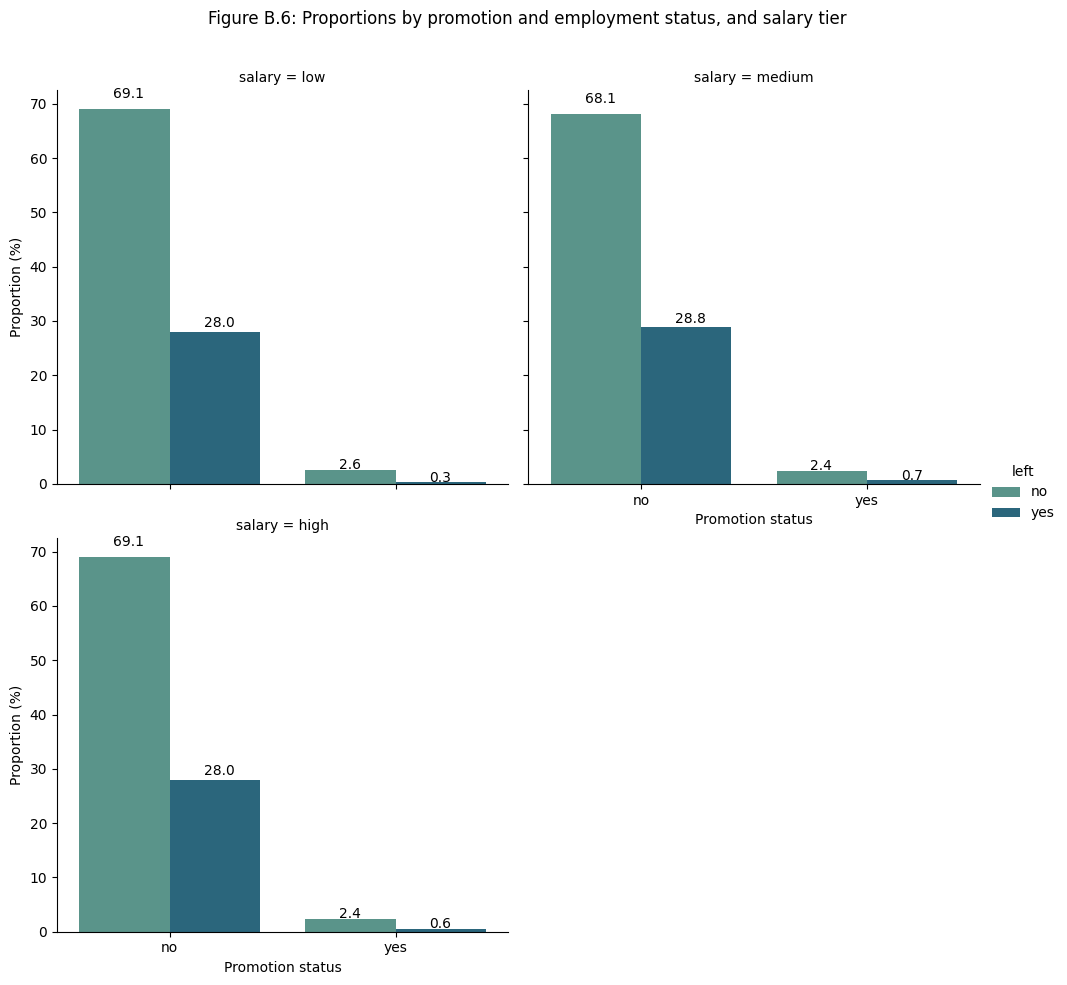

In [33]:
temp = data.groupby("salary")["promoted", "left"].value_counts(normalize=True)
temp = pd.DataFrame(temp).reset_index()
temp.columns = ['salary', 'promoted', 'left', 'prop']
temp.prop = temp.prop.mul(100)
temp

pl = sns.catplot(x="promoted", y="prop", hue="left", col="salary", col_wrap=2, data=temp, kind="bar", 
                 palette="crest", height=5, aspect=1)
pl.set_axis_labels("Promotion status", "Proportion (%)")
pl.fig.subplots_adjust(top=0.9)
pl.fig.suptitle("Figure B.6: Proportions by promotion and employment status, and salary tier");

# extract the matplotlib axes_subplot objects from the FacetGrid
for col in [0,1,2]:
    ax = pl.facet_axis(0,col)
    # iterate through the axes patches
    for pat in ax.patches:
        ax.text(pat.get_x() + 0.15, 
                pat.get_height() * 1.03, 
               '{0:.1f}'.format(pat.get_height()),
                color='black', 
                rotation = 'horizontal', 
                size = 'medium')

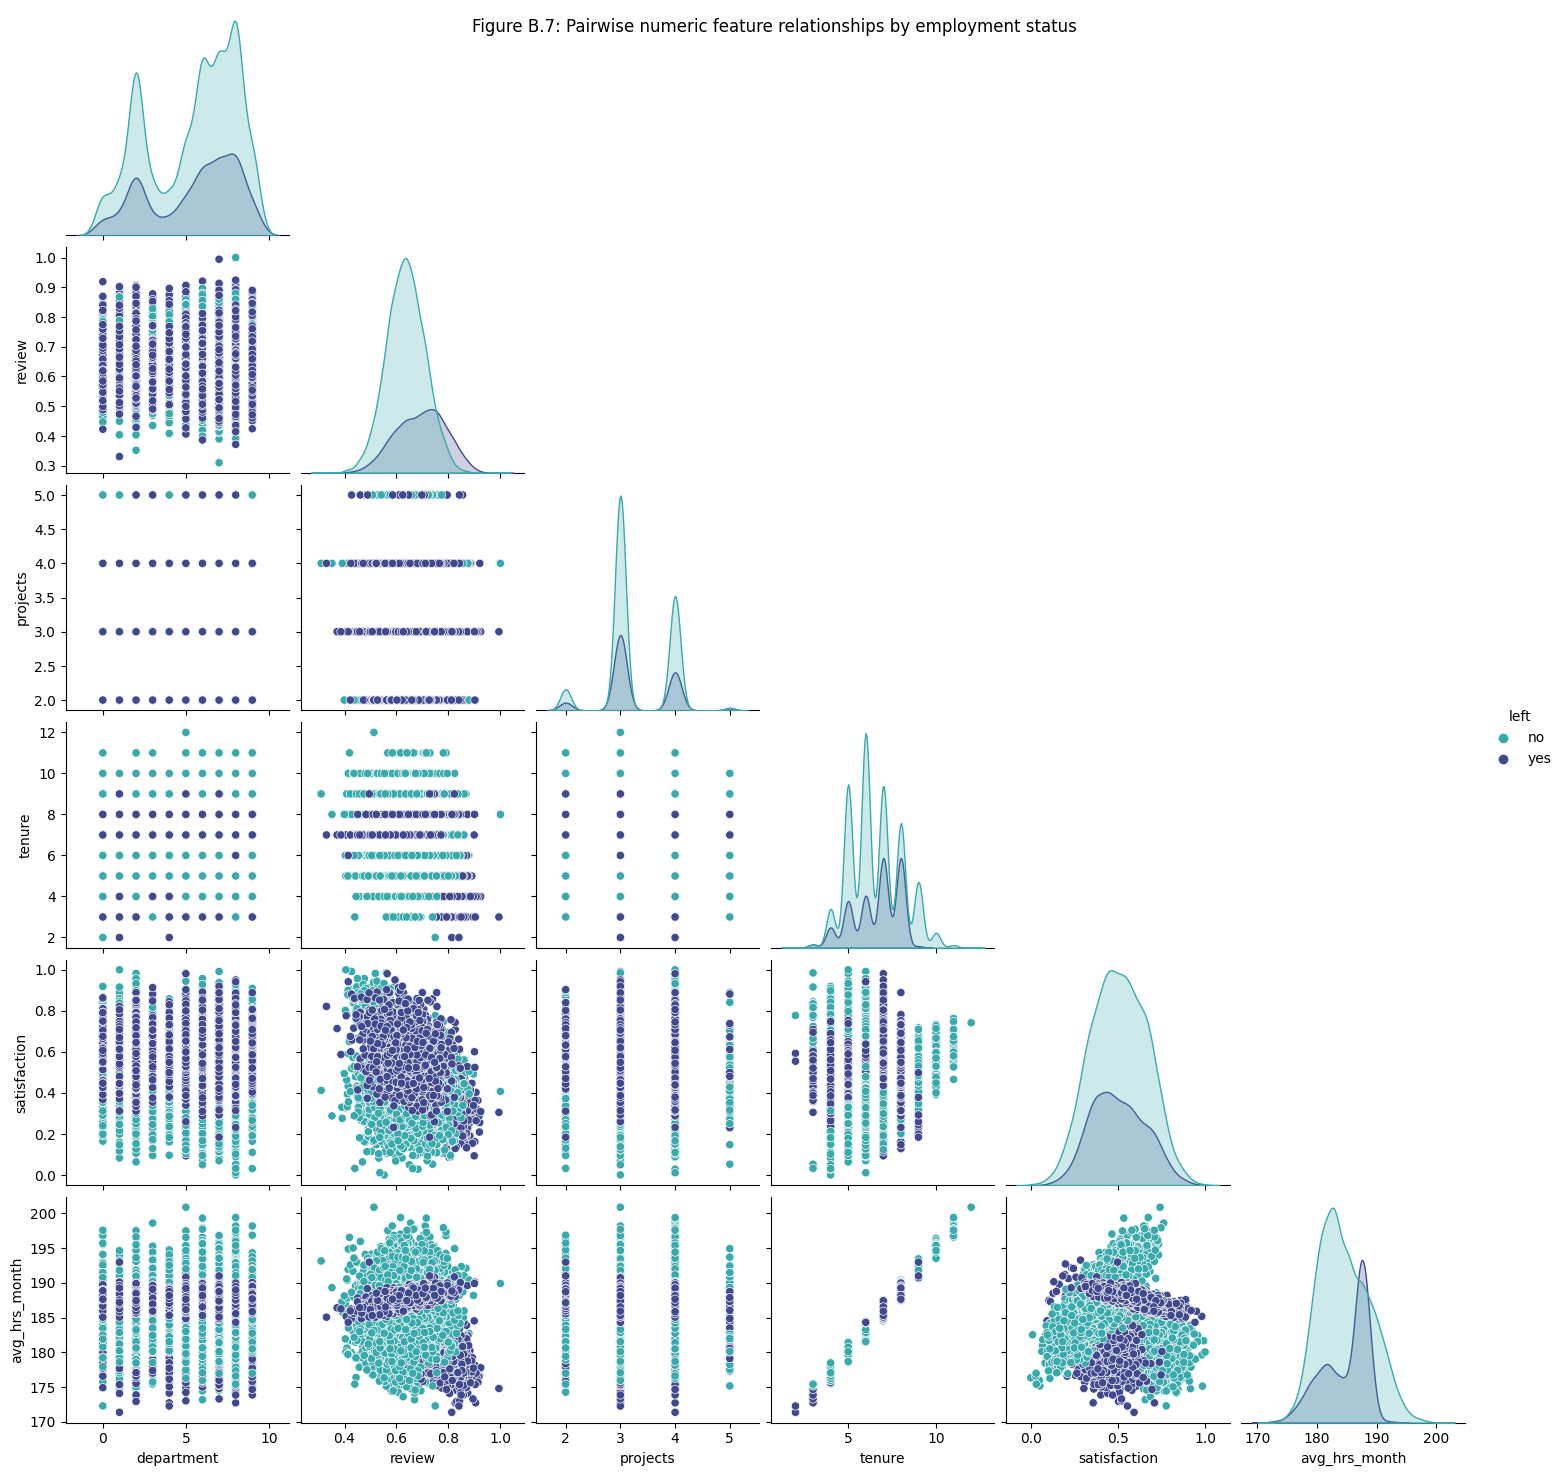

In [34]:
# drop features with three or fewer distinct categories to reduce the size of the pairplot
data_num.drop(['promoted', 'bonus', 'salary'], axis=1, inplace=True)

# create the pairplot
g = sns.pairplot(data_num, hue="left", corner=True, palette ="mako_r")
g.fig.suptitle("Figure B.7: Pairwise numeric feature relationships by employment status");

## Appendix C: Additional modelling figures and tables

In [35]:
print("Table C.1: Baseline model performance metrics on the training data")
train_baseline_perf_metrics.sort_values(by=['f1 score'], ascending=False)

Table C.1: Baseline model performance metrics on the training data


model  accuracy  f1 score   roc auc    pr auc  precision  \
2             ExtraTrees  1.000000  1.000000  1.000000  1.000000   1.000000   
3          Decision Tree  1.000000  1.000000  1.000000  1.000000   1.000000   
8          Random Forest  1.000000  1.000000  1.000000  1.000000   1.000000   
1               CatBoost  0.890461  0.828969  0.962703  0.918836   0.761368   
0               AdaBoost  0.877621  0.811008  0.963388  0.925703   0.738122   
5   K-Nearest Neighbours  0.871200  0.770058  0.937754  0.878465   0.803711   
4      Gradient Boosting  0.874607  0.768112  0.937112  0.879393   0.834211   
9         Support Vector  0.818396  0.734177  0.914773  0.810927   0.640777   
6    Logistic Regression  0.725367  0.614138  0.808884  0.599068   0.520437   
7            Naive Bayes  0.695231  0.396471  0.727060  0.458190   0.469576   
10             Base Rate  0.708202  0.000000  0.500000  0.000000   0.000000   

      recall  specificity  false positive rate  false negative rate  
2   1.000000     1.000000             0.000000             0.000000  
3   1.000000     1.000000             0.000000             0.000000  
8   1.000000     1.000000             0.000000             0.000000  
1   0.909744     0.882516             0.117484             0.090256  
0   0.899865     0.868455             0.131545             0.100135  
5   0.739111     0.925624             0.074376             0.260889  
4   0.711720     0.941721             0.058279             0.288280  
9   0.859452     0.801480             0.198520             0.140548  
6   0.748990     0.715634             0.284366             0.251010  
7   0.343062     0.840333             0.159667             0.656938  
10  0.000000     1.000000             0.000000             1.000000

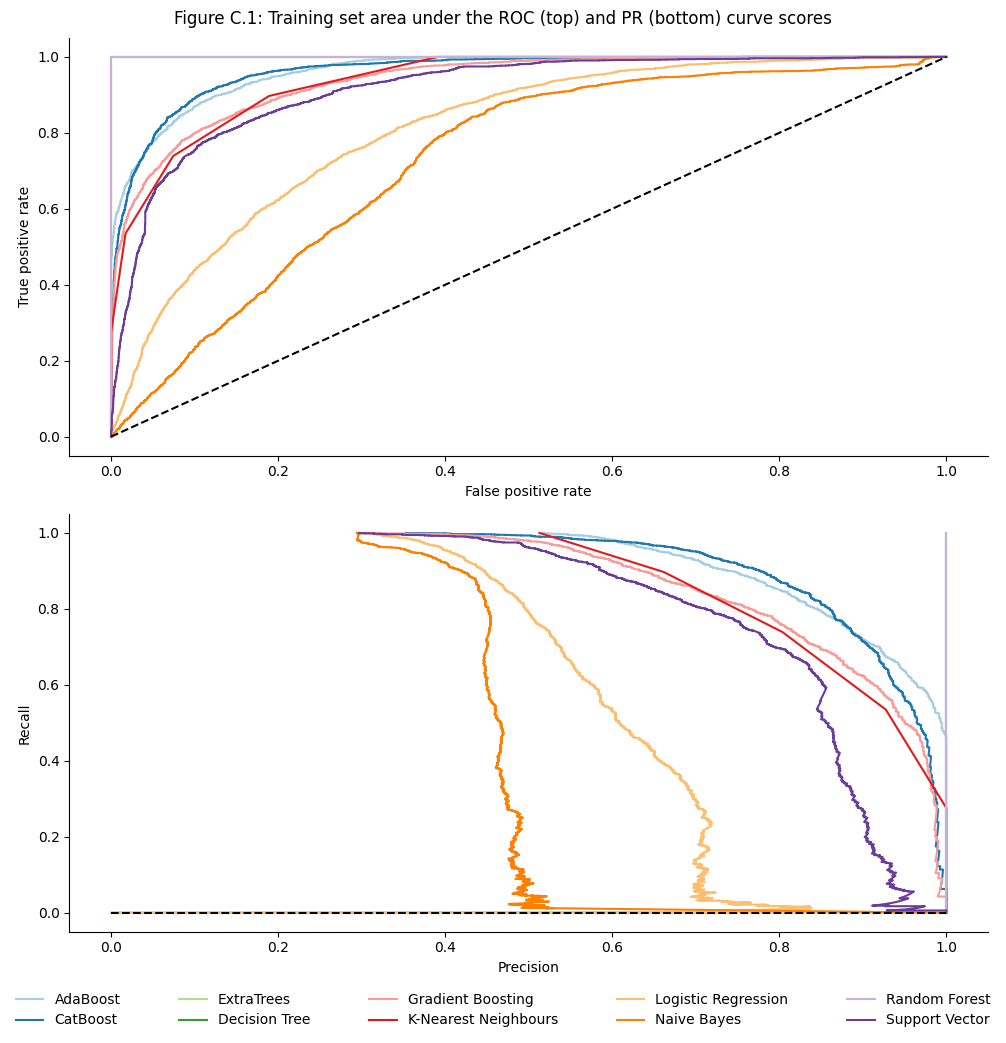

In [36]:
# set the colour scheme
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Paired.colors)

# call the function on the baseline model training data
model_names = ["AdaBoost", "CatBoost", "ExtraTrees", "Decision Tree", "Gradient Boosting", 
               "K-Nearest Neighbours", "Logistic Regression", "Naive Bayes", "Random Forest", 
               "Support Vector"]
plot_roc_pr_auc_curves(data_subset='Training', 
                       fpr_data=baseline_metric_obs.train_fprss, 
                       tpr_data=baseline_metric_obs.train_tprss,
                       precision_data=baseline_metric_obs.train_precisionss, 
                       recall_data=baseline_metric_obs.train_recallss, 
                       fignum='C.1')

In [37]:
print("Table C.2: Tuned model performance metrics on the training data")
train_tuned_perf_metrics = tuned_metric_obs.train_perf_metrics
train_tuned_perf_metrics.sort_values(by=['f1 score'], ascending=False)

Table C.2: Tuned model performance metrics on the training data


model  accuracy  f1 score   roc auc    pr auc  precision  \
4      Random Forest  0.932259  0.888937  0.983870  0.962193   0.852142   
1           CatBoost  0.886530  0.822759  0.958758  0.911212   0.755923   
3  Gradient Boosting  0.894523  0.806723  0.954095  0.908912   0.866873   
0           AdaBoost  0.850760  0.772154  0.944448  0.891705   0.696248   
2      Decision Tree  0.795991  0.714783  0.907837  0.812747   0.603651   

     recall  specificity  false positive rate  false negative rate  
4  0.929053     0.933580             0.066420             0.070947  
1  0.902559     0.879926             0.120074             0.097441  
3  0.754378     0.952266             0.047734             0.245622  
0  0.866637     0.844218             0.155782             0.133363  
2  0.876066     0.762997             0.237003             0.123934

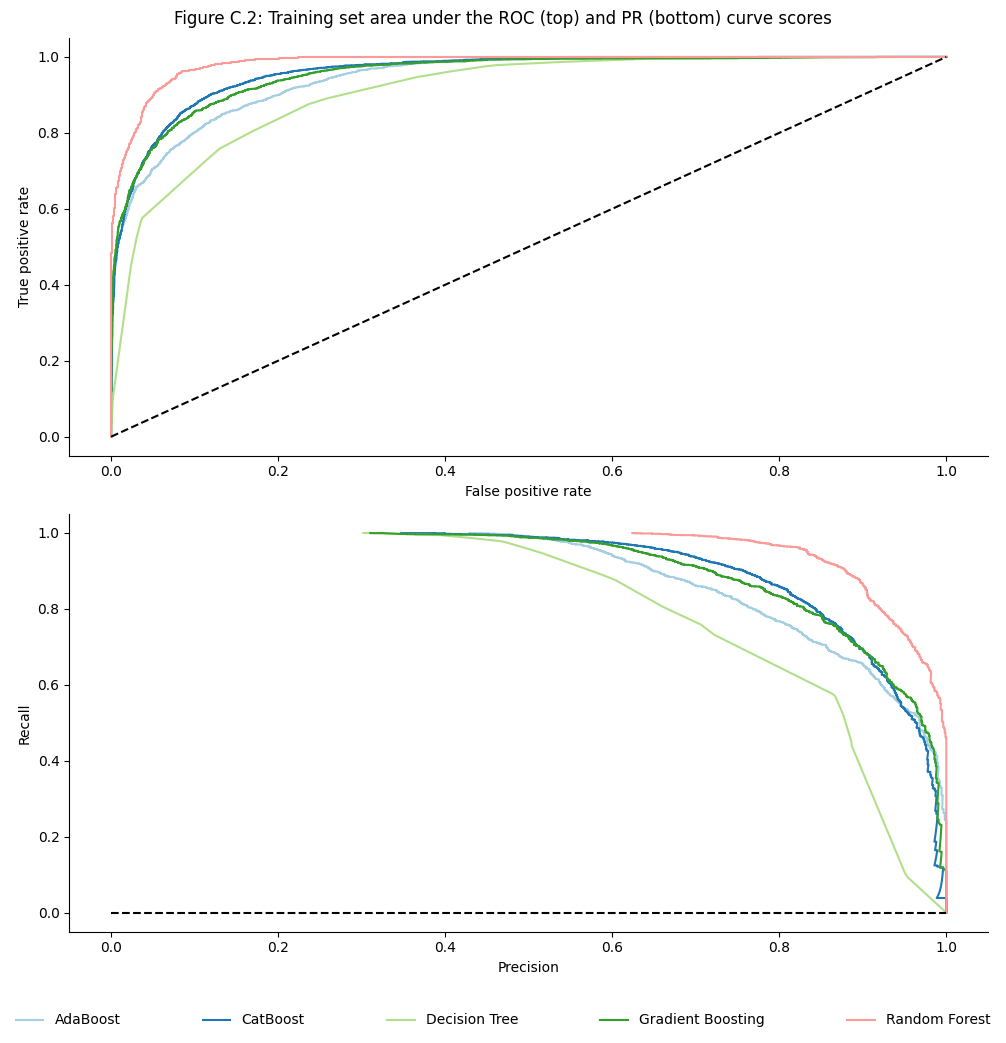

In [38]:
# call the function on the tuned model training data
model_names = ["AdaBoost", "CatBoost", "Decision Tree", "Gradient Boosting", "Random Forest"]
plot_roc_pr_auc_curves(data_subset='Training', 
                       fpr_data=tuned_metric_obs.train_fprss, 
                       tpr_data=tuned_metric_obs.train_tprss,
                       precision_data=tuned_metric_obs.train_precisionss, 
                       recall_data=tuned_metric_obs.train_recallss, 
                       fignum='C.2')

# reset rcparams to the default settings
plt.rcParams.update(mpl.rcParamsDefault)

## Appendix D: Additional feature importance figures

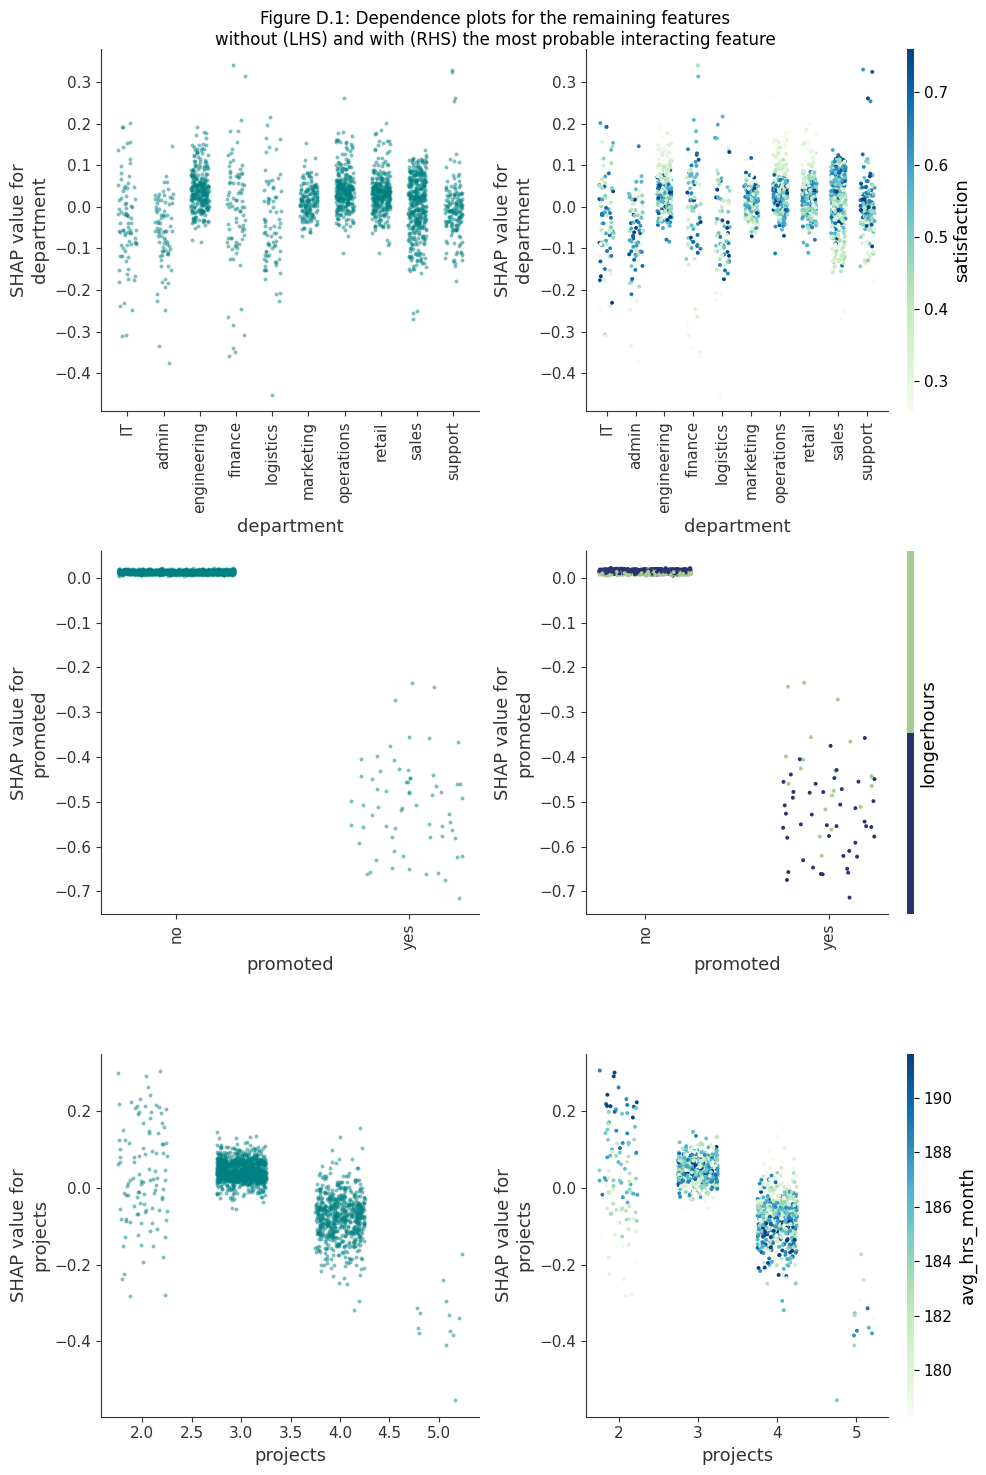

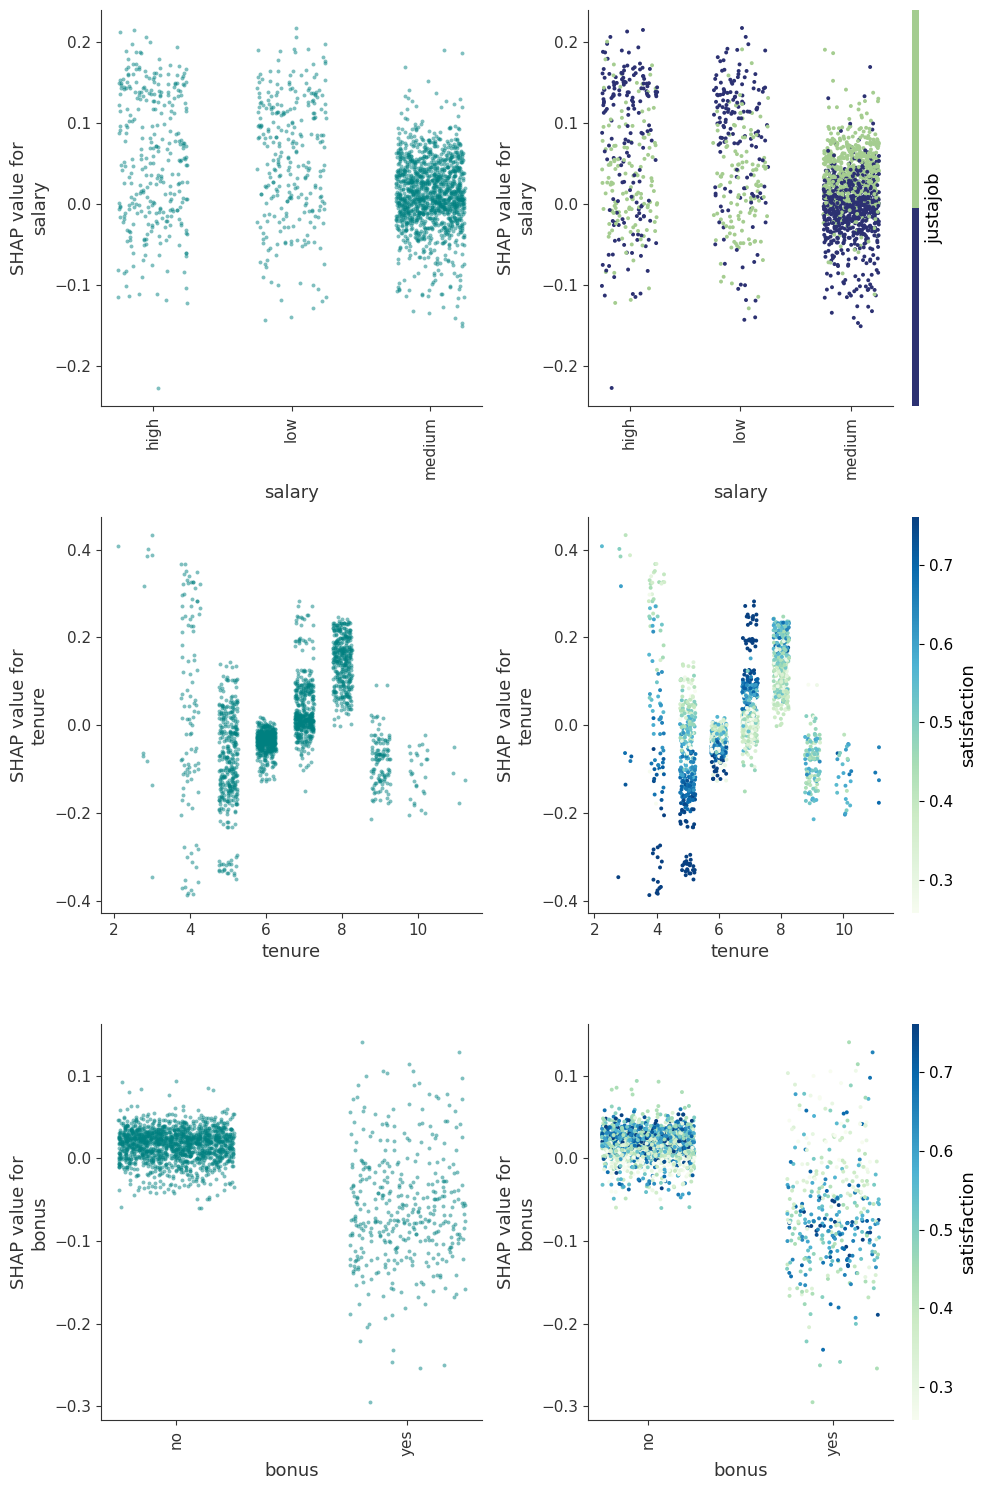

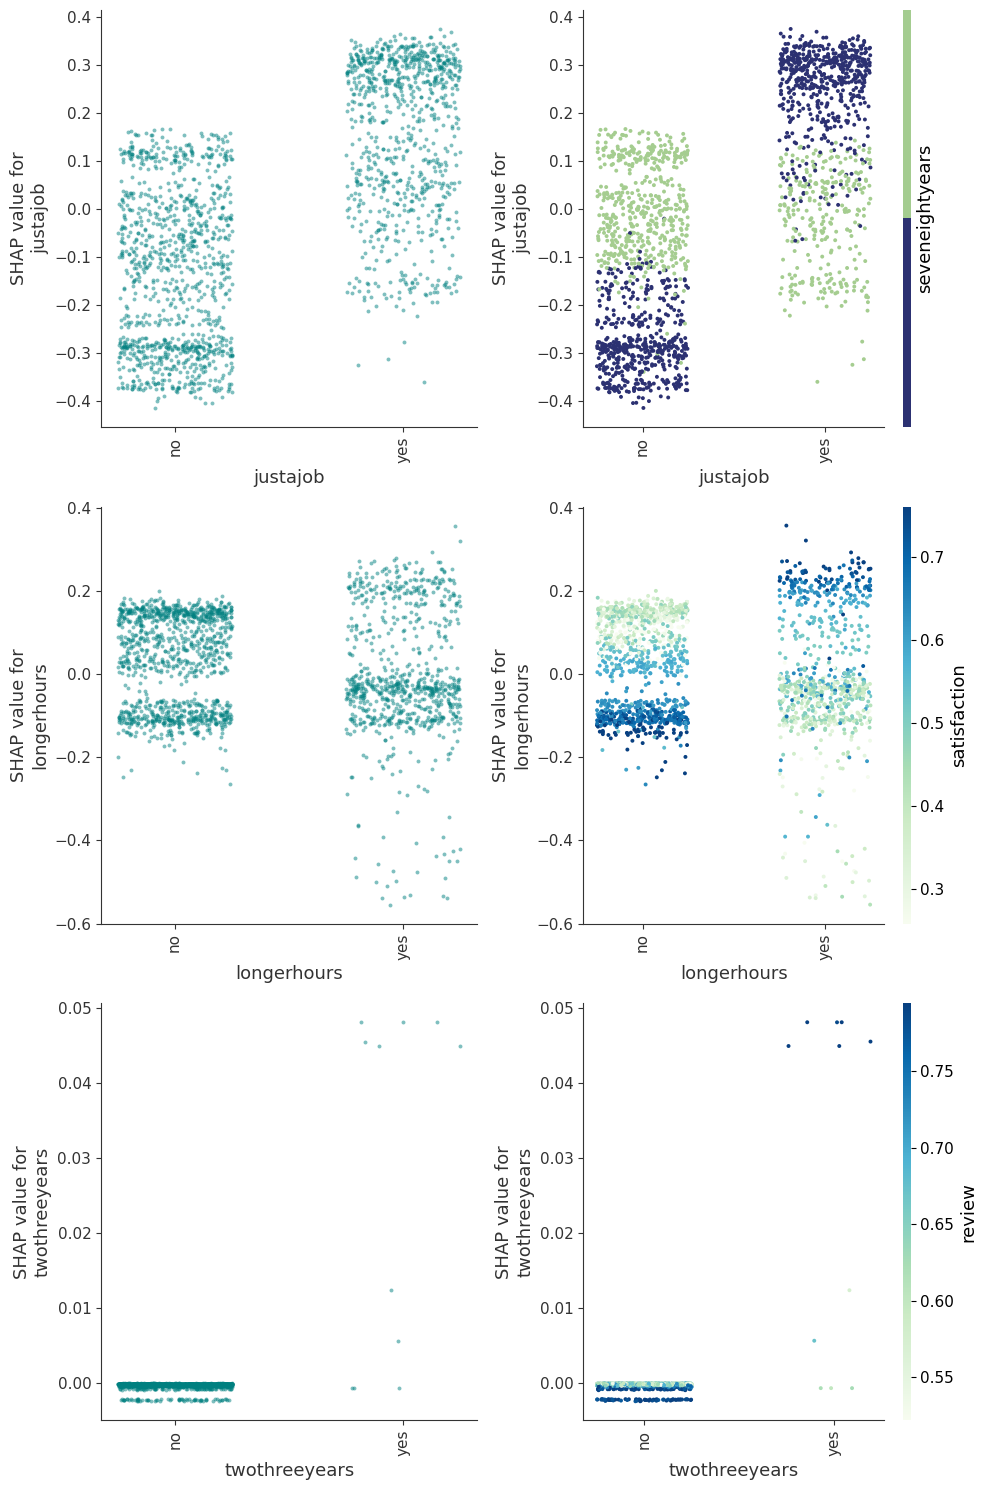

In [39]:
fig, axs = plt.subplots(3, 2, figsize=(10,15))

shap.dependence_plot(0, shap_values.values, X_test, color="teal", alpha=0.5, 
                     interaction_index=None, show=False, x_jitter=0.5, dot_size=8, ax=axs[0,0])
shap.dependence_plot(1, shap_values.values, X_test, color="teal", alpha=0.5, 
                     interaction_index=None, show=False, x_jitter=0.5, dot_size=8, ax=axs[1,0])
shap.dependence_plot(3, shap_values.values, X_test, color="teal", alpha=0.5, 
                     interaction_index=None, show=False, x_jitter=0.5, dot_size=8, ax=axs[2,0])

shap.dependence_plot(0, shap_values.values, X_test, cmap=plt.get_cmap("GnBu"), show=False, 
                     x_jitter=0.5, dot_size=8, ax=axs[0,1])
shap.dependence_plot(1, shap_values.values, X_test, cmap=plt.get_cmap("crest_r"), show=False, 
                     x_jitter=0.5, dot_size=8, ax=axs[1,1])
shap.dependence_plot(3, shap_values.values, X_test, cmap=plt.get_cmap("GnBu"), show=False, 
                     x_jitter=0.5, dot_size=8, ax=axs[2,1])

fig.suptitle("Figure D.1: Dependence plots for the remaining features\nwithout (LHS) and with (RHS) the most probable interacting feature")
fig.tight_layout();


fig, axs = plt.subplots(3, 2, figsize=(10,15))

shap.dependence_plot(4, shap_values.values, X_test, color="teal", alpha=0.5, 
                     interaction_index=None, show=False, x_jitter=0.5, dot_size=8, ax=axs[0,0])
shap.dependence_plot(5, shap_values.values, X_test, color="teal", alpha=0.5, 
                     interaction_index=None, show=False, x_jitter=0.5, dot_size=8, ax=axs[1,0])
shap.dependence_plot(7, shap_values.values, X_test, color="teal", alpha=0.5, 
                     interaction_index=None, show=False, x_jitter=0.5, dot_size=8, ax=axs[2,0])

shap.dependence_plot(4, shap_values.values, X_test, cmap=plt.get_cmap("crest_r"), show=False, 
                     x_jitter=0.5, dot_size=8, ax=axs[0,1])
shap.dependence_plot(5, shap_values.values, X_test, cmap=plt.get_cmap("GnBu"), show=False, 
                     x_jitter=0.5, dot_size=8, ax=axs[1,1])
shap.dependence_plot(7, shap_values.values, X_test, cmap=plt.get_cmap("GnBu"), show=False, 
                     x_jitter=0.5, dot_size=8, ax=axs[2,1])

fig.tight_layout();


fig, axs = plt.subplots(3, 2, figsize=(10,15))

shap.dependence_plot(9, shap_values.values, X_test, color="teal", alpha=0.5, 
                     interaction_index=None, show=False, x_jitter=0.5, dot_size=8, ax=axs[0,0])
shap.dependence_plot(10, shap_values.values, X_test, color="teal", alpha=0.5, 
                     interaction_index=None, show=False, x_jitter=0.5, dot_size=8, ax=axs[1,0])
shap.dependence_plot(12, shap_values.values, X_test, color="teal", alpha=0.5, 
                     interaction_index=None, show=False, x_jitter=0.5, dot_size=8, ax=axs[2,0])

shap.dependence_plot(9, shap_values.values, X_test, cmap=plt.get_cmap("crest_r"), show=False, 
                     x_jitter=0.5, dot_size=8, ax=axs[0,1])
shap.dependence_plot(10, shap_values.values, X_test, cmap=plt.get_cmap("GnBu"), show=False, 
                     x_jitter=0.5, dot_size=8, ax=axs[1,1])
shap.dependence_plot(12, shap_values.values, X_test, cmap=plt.get_cmap("GnBu"), show=False, 
                     x_jitter=0.5, dot_size=8, ax=axs[2,1])

fig.tight_layout();